# **Import Libraries**
The experiment utilizes several Python libraries to handle video processing, numerical computation, visualization, and report generation.

- **OpenCV (cv2)** enables frame-by-frame video capture and image color conversion.

- **MediaPipe** provides a pretrained deep learning framework for human pose estimation, allowing automatic extraction of body landmarks such as hip, knee, and ankle joints.

- **NumPy & Pandas** are used for mathematical calculations and tabular data management, respectively.

- **Matplotlib** handles data visualization and exports graphs into publication-quality figures.

- **Pathlib & PdfPages** assist in generating structured output directories and exporting complete PDF reports automatically.

In [62]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

Setting a higher DPI value ensures that all figures rendered in Notebook maintain high visual clarity suitable for project inclusion.

In [63]:
plt.rcParams["figure.dpi"] = 120

# **Utilities**

**1. Angle Calculation Function**

This function computes the joint angle at point b, given three anatomical landmarks a–b–c. The method follows the dot-product formula derived from the law of cosines:

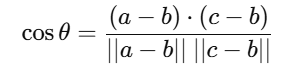

The formula outputs the enclosed angle between the two limb vectors in degrees. The function also includes a normalization step (clip) to prevent computational errors when the cosine value slightly exceeds its theoretical range due to floating-point precision. This function forms the mathematical foundation of biomechanical analysis in the system.

In [64]:
def calculate_angle(a, b, c):
    #Angle at point b (degrees) given 2D points a,b,c
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    denom = (np.linalg.norm(ba) * np.linalg.norm(bc)) + 1e-9
    cosine = np.clip(np.dot(ba, bc) / denom, -1.0, 1.0)
    return float(np.degrees(np.arccos(cosine)))

**2. Moving Average Smoothing**

Pose-estimation data often contain frame-to-frame fluctuations caused by landmark detection noise. To improve signal stability, a centered moving-average filter is applied. This filter replaces each data point with the mean of its neighboring points, effectively reducing noise while preserving the general trend of movement. The edge padding ensures the output series remains the same length as the original, which maintains temporal alignment across all variables.

In [65]:
def smooth_ma(x, window=7):
    #Centered moving average with edge padding; returns same length
    x = np.asarray(x, float)
    if window <= 1 or window > len(x):
        return x.copy()
    pad = window // 2
    xpad = np.pad(x, (pad, pad), mode="edge")
    kernel = np.ones(window) / window
    y = np.convolve(xpad, kernel, mode="valid")
    return y[:len(x)]

In [66]:
def format_df(df, nd=2):
    """Format numbers to fixed decimals; hide NaNs as empty strings."""
    out = df.copy()
    out = out.map(
        lambda x: "" if (x is None or (isinstance(x, float) and not np.isfinite(x)))
        else (f"{x:.{nd}f}" if isinstance(x, (float, np.floating, int, np.integer)) else x)
    )
    return out

**3. Pose Extraction and Feature Derivation (XY Coordinates from Video)**

In this stage, MediaPipe Pose is used to detect key body joints in each frame of the input video.  
For each frame, the 2D pixel coordinates of the **shoulder**, **hip**, **knee**, and **ankle** are extracted,  
and the corresponding **joint angles** are computed using the previous function.

Outputs per frame include:
- **Knee and hip angles (raw + smoothed)**  
- **Knee angular velocity (°/s)** computed via numerical differentiation  
- **X, Y coordinates** of key joints for trajectory visualization

The output DataFrame preserves frame indices and timestamps,  
allowing time-based analysis and alignment between the fresh and tired sessions.

In [67]:
def extract_angles_and_xy(video_path, side="RIGHT", ma_window=7):
    """
    Returns df with:
      - time_s, knee_angle(_smooth), hip_angle(_smooth), knee_vel (deg/s)
      - XY in pixels for shoulder/hip/knee/ankle
    """
    video_path = str(video_path)
    mp_pose = mp.solutions.pose

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    idx = mp_pose.PoseLandmark
    if side.upper() == "RIGHT":
        SHO, HIP, KNEE, ANKLE = (
            idx.RIGHT_SHOULDER.value,
            idx.RIGHT_HIP.value,
            idx.RIGHT_KNEE.value,
            idx.RIGHT_ANKLE.value,
        )
    else:
        SHO, HIP, KNEE, ANKLE = (
            idx.LEFT_SHOULDER.value,
            idx.LEFT_HIP.value,
            idx.LEFT_KNEE.value,
            idx.LEFT_ANKLE.value,
        )

    frames, times = [], []
    knee, hip = [], []
    sho_x, sho_y, hip_x, hip_y, kne_x, kne_y, ank_x, ank_y = [], [], [], [], [], [], [], []

    with mp_pose.Pose(static_image_mode=False) as pose:
        f = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            h, w = frame.shape[:2]
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image)

            knee_ang = np.nan
            hip_ang = np.nan
            Sx = Sy = Hx = Hy = Kx = Ky = Ax = Ay = np.nan

            if results.pose_landmarks:
                lm = results.pose_landmarks.landmark
                Sx, Sy = lm[SHO].x * w, lm[SHO].y * h
                Hx, Hy = lm[HIP].x * w, lm[HIP].y * h
                Kx, Ky = lm[KNEE].x * w, lm[KNEE].y * h
                Ax, Ay = lm[ANKLE].x * w, lm[ANKLE].y * h

                shoulder = [lm[SHO].x,  lm[SHO].y]
                hipP     = [lm[HIP].x,  lm[HIP].y]
                kneeP    = [lm[KNEE].x, lm[KNEE].y]
                ankle    = [lm[ANKLE].x,lm[ANKLE].y]
                knee_ang = calculate_angle(hipP, kneeP, ankle)      # hip–knee–ankle
                hip_ang  = calculate_angle(shoulder, hipP, kneeP)   # shoulder–hip–knee

            frames.append(f)
            times.append(f / fps)
            knee.append(knee_ang)
            hip.append(hip_ang)
            sho_x.append(Sx); sho_y.append(Sy)
            hip_x.append(Hx); hip_y.append(Hy)
            kne_x.append(Kx); kne_y.append(Ky)
            ank_x.append(Ax); ank_y.append(Ay)
            f += 1

    cap.release()

    df = pd.DataFrame({
        "frame": frames, "time_s": times,
        "knee_angle": knee, "hip_angle": hip,
        "sho_x": sho_x, "sho_y": sho_y,
        "hip_x": hip_x, "hip_y": hip_y,
        "knee_x": kne_x, "knee_y": kne_y,
        "ankle_x": ank_x, "ankle_y": ank_y
    })

    # interpolate & smooth
    for col in ["knee_angle","hip_angle","sho_x","sho_y","hip_x","hip_y","knee_x","knee_y","ankle_x","ankle_y"]:
        df[col] = pd.Series(df[col]).interpolate(limit_direction="both")

    df["knee_angle_smooth"] = smooth_ma(df["knee_angle"].values, ma_window)
    df["hip_angle_smooth"]  = smooth_ma(df["hip_angle"].values, ma_window)

    # knee angular velocity (deg/s) — FIX: use time vector directly
    t = df["time_s"].values
    df["knee_vel"] = np.gradient(df["knee_angle_smooth"].values, t)

    return df, fps

**4. Summary Statistics per Session**

To provide a high-level overview, we calculate descriptive statistics of the smoothed knee angle for each session:
- **Mean:** average joint flexion angle  
- **Standard deviation:** variation of movement amplitude  
- **Minimum & maximum:** extreme flexion/extension angles  
- **Range:** difference between max and min (i.e., range of motion)  
- **n_frames:** number of valid frames analyzed

These statistics form the basis for later comparison tables and fatigue indicators.

In [68]:
def quick_stats(df):
    s = pd.Series(df["knee_angle_smooth"]).dropna().values
    if len(s) == 0:
        return {"mean": np.nan, "std": np.nan, "min": np.nan, "max": np.nan, "range": np.nan, "n_frames": len(df)}
    return {
        "mean": float(np.mean(s)),
        "std": float(np.std(s, ddof=1)) if len(s) > 1 else 0.0,
        "min": float(np.min(s)),
        "max": float(np.max(s)),
        "range": float(np.max(s) - np.min(s)),
        "n_frames": int(len(s))
    }

**5. Repetition Segmentation and Per-Rep Features**

To analyze performance across individual squat cycles, the smoothed knee-angle signal is segmented into repetitions.  
A **zero-crossing approach** on the knee angular-velocity curve detects local minima (transition from eccentric to concentric phase).  
A temporal refractory period ensures that consecutive detections represent separate squats rather than noise.  

For each repetition, we extract biomechanical descriptors:
- **Knee ROM (°)** – difference between maximum and minimum knee angle.  
- **Hip ROM (°)** – same computation applied to the hip joint.  
- **Ascent time (s)** – time taken from the lowest to the highest point.  
- **Descent time (s)** – time taken from the top to the next bottom.  
- **Peak knee angular velocity (°/s)** – highest absolute angular-velocity value during the cycle.

These parameters allow comparison of movement amplitude and tempo between fresh and tired states.

In [69]:
def segment_reps(df, fps, min_separation_s=1.0):
    ang = df["knee_angle_smooth"].values
    vel = df["knee_vel"].values

    # primary: zero-crossings (neg->pos)
    sign = np.sign(vel)
    minima = np.where((sign[:-1] < 0) & (sign[1:] > 0))[0] + 1

    # refractory
    keep = []
    last = -10**9
    min_sep = int(min_separation_s * fps)
    for i in minima:
        if i - last >= min_sep:
            keep.append(i); last = i
    mins = np.array(keep, dtype=int)

    # fallback: local-min window if not enough
    if len(mins) < 2:
        w = max(int(0.35 * fps), 3)  # ~350 ms neighborhood
        cand = []
        for i in range(w, len(ang)-w):
            neighborhood = ang[i-w:i+w+1]
            if np.argmin(neighborhood) == w:
                cand.append(i)
        keep = []
        last = -10**9
        for i in cand:
            if i - last >= min_sep:
                keep.append(i); last = i
        mins = np.array(keep, dtype=int)

    reps = []
    for i in range(len(mins)-1):
        lo, hi = mins[i], mins[i+1]
        if hi <= lo+2:
            continue
        seg = ang[lo:hi]
        max_idx = lo + int(np.argmax(seg))
        reps.append((lo, mins[i], max_idx, hi))
    return reps

In [70]:
def per_rep_features(df, reps):
    #Return per-rep DataFrame with knee/hip ROM, ascent/descent times, peak knee angular velocity."""
    feats = []
    t = df["time_s"].values
    k = df["knee_angle_smooth"].values
    h = df["hip_angle_smooth"].values
    v = df["knee_vel"].values
    for (start_i, min_i, max_i, end_i) in reps:
        kmin, kmax = k[min_i], k[max_i]
        ROM_knee = kmax - kmin
        ROM_hip  = (h[max_i] - h[min_i]) if np.isfinite(h[max_i]) and np.isfinite(h[min_i]) else np.nan
        ascent_t  = t[max_i] - t[min_i]
        descent_t = t[end_i] - t[max_i]
        peak_vel  = np.nanmax(np.abs(v[min_i:end_i])) if end_i > min_i else np.nan
        feats.append({
            "rep_start_s": float(t[start_i]), "rep_end_s": float(t[end_i]),
            "knee_ROM": float(ROM_knee), "hip_ROM": float(ROM_hip),
            "ascent_time_s": float(ascent_t), "descent_time_s": float(descent_t),
            "knee_peak_vel_deg_s": float(peak_vel)
        })
    return pd.DataFrame(feats)

**6. Spatial Trajectory Metrics and Smoothness**

Beyond angular kinematics, the two-dimensional paths of the knee and hip provide insights into **movement control**.  
Three trajectory-based metrics are extracted:

- **Path length (px):** total Euclidean distance traveled by a joint across frames.  
- **Mean speed (px/s):** average instantaneous speed.  
- **Jerk RMS:** root-mean-square of the third derivative of position (a proxy for smoothness; lower jerk = smoother motion).  

Together, these values help characterize how fatigue affects movement consistency and spatial control.

In [71]:
def path_length(x, y):
    dx = np.diff(x); dy = np.diff(y)
    return float(np.nansum(np.sqrt(dx*dx + dy*dy)))

def mean_speed(x, y, t):
    dx = np.diff(x); dy = np.diff(y); dt = np.diff(t)
    step_d = np.sqrt(dx*dx + dy*dy)
    step_v = np.divide(step_d, np.clip(dt, 1e-6, None))
    return float(np.nanmean(step_v))

def smoothness_jerk(x, y, t):
    vx = np.gradient(x, t); vy = np.gradient(y, t)
    ax = np.gradient(vx, t); ay = np.gradient(vy, t)
    jx = np.gradient(ax, t); jy = np.gradient(ay, t)
    jerk_mag = np.sqrt(jx*jx + jy*jy)
    return float(np.nanmean(jerk_mag))

def trajectory_summary(df):
    t = df["time_s"].values
    out = {}
    for joint in ["knee", "hip"]:
        x = df[f"{joint}_x"].values
        y = df[f"{joint}_y"].values
        out[f"{joint}_path_len_px"]     = path_length(x, y)
        out[f"{joint}_mean_speed_px_s"] = mean_speed(x, y, t)
        out[f"{joint}_jerk_rms"]        = smoothness_jerk(x, y, t)
    return out

**7. Dynamic Time Warping (DTW) for Signal Similarity**

To quantify overall similarity between fresh and tired motions, **Dynamic Time Warping (DTW)** aligns two temporal sequences (e.g., knee-angle curves) even when they differ in duration or tempo. A larger DTW distance implies greater dissimilarity, indicating potential alterations in movement patterns under fatigue.

In [72]:
def resample_series(x,n=300):
    x=np.asarray(x,float)
    return np.interp(np.linspace(0,1,n), np.linspace(0,1,len(x)), x)

def dtw_distance(a,b):
    A,B=np.asarray(a),np.asarray(b)
    n,m=len(A),len(B)
    D=np.full((n+1,m+1),np.inf); D[0,0]=0
    for i in range(1,n+1):
        for j in range(1,m+1):
            cost=abs(A[i-1]-B[j-1])
            D[i,j]=cost+min(D[i-1,j],D[i,j-1],D[i-1,j-1])
    return float(D[n,m])

def dtw_compare_angles(df_f, df_t, n=300):
    af,at=resample_series(df_f["knee_angle_smooth"],n),resample_series(df_t["knee_angle_smooth"],n)
    hf,ht=resample_series(df_f["hip_angle_smooth"],n),resample_series(df_t["hip_angle_smooth"],n)
    return {"dtw_knee_angle": dtw_distance(af,at),"dtw_hip_angle":dtw_distance(hf,ht)}

**8. Dynamic Time Warping on 2-D Knee Trajectory**

While above cell compares **angle curves** using DTW, fatigue may also alter the **spatial path** of the knee.  
To compare 2-D trajectories fairly, we first resample the knee **X** and **Y** series to a common length and convert each to a **radius-like magnitude** around its own mean (i.e., deviation from the mean path).  
This yields two 1-D signals (`mf`, `mt`) that summarize spatial excursion over time for fresh vs. tired.  
A higher DTW distance indicates greater dissimilarity of knee path geometry between the two states.

In [73]:
def dtw_compare_knee_xy(df_fresh, df_tired, n=300):
    xf = resample_series(df_fresh["knee_x"].values, n)
    yf = resample_series(df_fresh["knee_y"].values, n)
    xt = resample_series(df_tired["knee_x"].values, n)
    yt = resample_series(df_tired["knee_y"].values, n)
    mf = np.sqrt((xf - np.nanmean(xf))**2 + (yf - np.nanmean(yf))**2)
    mt = np.sqrt((xt - np.nanmean(xt))**2 + (yt - np.nanmean(yt))**2)
    return {"dtw_knee_xy": dtw_distance(mf, mt)}

**9. Rule-Based Fatigue Verdicts**

To provide an interpretable decision alongside continuous metrics, we include two simple rule sets:

- **Basic rule:** flags fatigue when the **mean knee angle** or **knee ROM** (range) drops beyond practical thresholds.
- **Extended rule:** adds changes in **peak knee angular velocity** and **ascent time**, expressed in percentage, to capture tempo loss.

These thresholds are conservative defaults suitable for pilot analysis and can be tightened/relaxed depending on cohort variability and sampling noise.

In [74]:
def simple_fatigue_flag(stats_fresh, stats_tired, mean_drop_thr=3.0, range_drop_thr=5.0):
    mean_drop  = stats_fresh["mean"]  - stats_tired["mean"]
    range_drop = stats_fresh["range"] - stats_tired["range"]
    flags = []
    if mean_drop > mean_drop_thr:
        flags.append(f"Mean knee angle ↓ {mean_drop:.1f}°")
    if range_drop > range_drop_thr:
        flags.append(f"Knee ROM ↓ {range_drop:.1f}°")
    verdict = "Fatigue likely" if flags else "No strong fatigue signal"
    return verdict, flags

def fatigue_rule_extended(stats_f, stats_t, agg_f, agg_t,
                          mean_drop_thr=3.0, range_drop_thr=5.0,
                          vel_drop_pct=15.0, asc_increase_pct=15.0):
    flags = []
    mean_drop  = stats_f["mean"]  - stats_t["mean"]
    range_drop = stats_f["range"] - stats_t["range"]
    if mean_drop > mean_drop_thr:
        flags.append(f"Mean knee angle ↓ {mean_drop:.1f}°")
    if range_drop > range_drop_thr:
        flags.append(f"Knee ROM ↓ {range_drop:.1f}°")

    if np.isfinite(agg_f.get("knee_peak_vel_deg_s", np.nan)) and np.isfinite(agg_t.get("knee_peak_vel_deg_s", np.nan)):
        v_drop = 100.0 * (agg_f["knee_peak_vel_deg_s"] - agg_t["knee_peak_vel_deg_s"]) / max(agg_f["knee_peak_vel_deg_s"], 1e-6)
        if v_drop >= vel_drop_pct:
            flags.append(f"Peak knee ang. vel ↓ {v_drop:.0f}%")

    if np.isfinite(agg_f.get("ascent_time_s", np.nan)) and np.isfinite(agg_t.get("ascent_time_s", np.nan)):
        asc_up = 100.0 * (agg_t["ascent_time_s"] - agg_f["ascent_time_s"]) / max(agg_f["ascent_time_s"], 1e-6)
        if asc_up >= asc_increase_pct:
            flags.append(f"Ascent time ↑ {asc_up:.0f}%")

    verdict = "Fatigue" if flags else "No Fatigue"
    return verdict, flags

**10. Shared Axis Limits for Fair Visual Comparison**

To ensure accurate side-by-side comparison, both fresh and tired trajectory plots must use the same X/Y scale.
This helper calculates shared limits with a small 5% padding, keeping visual proportions identical across subplots.

- Purpose: Prevents visual distortion due to auto-scaled axes.

- Method: Concatenates X/Y values from both sessions, finds min–max, and adds padding.

- Output: Returns (xlim, ylim) tuples used by plotting functions.

These consistent scales make the trajectory shape directly comparable and reproducible in reports.

In [75]:
def _common_limits(df_fresh, df_tired, joint):
    # Compute shared x/y limits with 5% padding so both subplots use identical scales.
    x_all = np.concatenate([df_fresh[f"{joint}_x"].values, df_tired[f"{joint}_x"].values])
    y_all = np.concatenate([df_fresh[f"{joint}_y"].values, df_tired[f"{joint}_y"].values])
    xpad = 0.05 * (np.nanmax(x_all) - np.nanmin(x_all) + 1e-6)
    ypad = 0.05 * (np.nanmax(y_all) - np.nanmin(y_all) + 1e-6)
    xlim = (np.nanmin(x_all) - xpad, np.nanmax(x_all) + xpad)
    ylim = (np.nanmax(y_all) + ypad, np.nanmin(y_all) - ypad)  # invert for image coords
    return xlim, ylim

**11. 2-D Trajectory Plotter**

This function plots fresh vs tired joint trajectories using the shared axis limits computed earlier.

- Inputs: df_fresh, df_tired, and joint name (e.g., "knee" or "hip").

- Customization: Control figure ratio via box_aspect, and label placement with legend_loc.

- Output: Clean trajectory plot for each joint, visually comparable between sessions.

This visualization helps identify movement drift, reduced range, or altered trajectory under fatigue.

In [76]:
def plot_xy_trajectories(df_fresh, df_tired, joint="knee", ax=None, title=None,
                         box_aspect=0.55, linewidth=2, legend_loc="best"):
    """
    Compact rectangular 2D trajectory with shared limits & aspect.
    box_aspect < 1.0 => wide; > 1.0 => tall.
    """
    if ax is None:
        ax = plt.gca()

    # Shared limits for this joint across both sessions
    xlim, ylim = _common_limits(df_fresh, df_tired, joint)

    ax.plot(df_fresh[f"{joint}_x"], df_fresh[f"{joint}_y"], linewidth=linewidth, label=f"Fresh {joint}")
    ax.plot(df_tired[f"{joint}_x"], df_tired[f"{joint}_y"], linewidth=linewidth, label=f"Tired {joint}")

    # start/end markers (small so they don't clutter)
    for df, c in [(df_fresh, 0), (df_tired, 1)]:
        x = df[f"{joint}_x"].values
        y = df[f"{joint}_y"].values
        if x.size:
            ax.scatter(x[0],  y[0],  s=18, marker="o")
            ax.scatter(x[-1], y[-1], s=18, marker="x")

    # Use identical limits + a controlled rectangular shape
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)            # already inverted via ylim order
    ax.set_box_aspect(box_aspect) # <- forces the “small wide” look
    ax.grid(True, alpha=0.35)
    ax.set_xlabel("X (px)"); ax.set_ylabel("Y (px)")
    ax.set_title(title or f"{joint.capitalize()} trajectory (Fresh vs Tired)", fontsize=11)
    ax.legend(loc=legend_loc, fontsize=8)

#  **Main Configuration — User Input Section**

In [77]:
fresh_video = 'P01_Fresh Squat.mov'
tired_video = 'P01_Tired Squat.mov'

SIDE = "RIGHT"         # or "LEFT"
MA_WINDOW = 7          # 5–11 is typical

p_name   = "P01_TAN JIE YING"
p_age    = "22"
p_gender = "FEMALE"
exercise_type = "Jogging"
exercise_duration = "15 minutes"

# Define title and subtitle
title = f"\nSTS Performance Report for {p_name}\n"
subtitle = f"\nAge: {p_age} • Gender: {p_gender} • Side: {SIDE} • Exercise: {exercise_type} • Duration of Exercise: {exercise_duration}\n"

Before running the full pipeline, specify the video files and participant details here.
This section personalizes the report output and ensures correct data paths.

Required fields:
fresh_video, tired_video, SIDE, MA_WINDOW, p_name, p_age, p_gender

Checklist:

- Upload both videos to Colab / working directory.

- Set analysis side ("RIGHT" / "LEFT").

- Choose smoothing window (typical 5–11).

- Fill in participant information.

Once filled, proceed to the next section to execute the pipeline.

# **Run Pipeline — Full Analysis Sequence**

This cell executes the complete motion-analysis workflow — from extracting pose data to generating fatigue verdicts and a one-page visual report.
It processes both fresh and tired sessions automatically and stores all intermediate results for visualization and export.

Key steps:

- Extract angles & XY coordinates (extract_angles_and_xy)
Detects knee and hip landmarks per frame, calculates angles, and smooths signals.

- Compute session statistics (quick_stats)
Summarizes mean, SD, min, max, and range of motion for each session.

- Detect repetitions (segment_reps)
Identifies individual squat cycles using knee velocity zero-crossings.

- Calculate per-rep features (per_rep_features)
Derives key temporal and kinematic measures — ROM, ascent/descent time, peak velocity.

- Aggregate metrics (agg_or_fallback)
Handles missing repetitions gracefully by falling back to session-level percentile estimates.

- Compare sessions with DTW (dtw_compare_angles, dtw_compare_knee_xy)
Quantifies shape and spatial similarity between fresh and tired motion profiles.

- Generate fatigue verdicts (simple_fatigue_flag, fatigue_rule_extended)
Provides interpretable rule-based conclusions with concise reasoning.

These outputs are automatically formatted, visualized, and compiled into a 1-page report (PNG + PDF) under outputs/<ParticipantName>/.

In [78]:
# 1) Extract per-frame data
df_fresh, fps_f = extract_angles_and_xy(fresh_video, SIDE, MA_WINDOW)
df_tired, fps_t = extract_angles_and_xy(tired_video, SIDE, MA_WINDOW)

# 2) Session stats
stats_f = quick_stats(df_fresh)
stats_t = quick_stats(df_tired)

# 3) Reps + per-rep features
reps_f = segment_reps(df_fresh, fps_f, min_separation_s=1.0)
reps_t = segment_reps(df_tired, fps_t, min_separation_s=1.0)
perrep_f = per_rep_features(df_fresh, reps_f) if len(reps_f) else pd.DataFrame()
perrep_t = per_rep_features(df_tired, reps_t) if len(reps_t) else pd.DataFrame()

# 4) Aggregates (fallback to session ROM if reps missing)
def agg_or_fallback(perrep_df, df_ts):
    if perrep_df.empty:
        agg = {
            "knee_ROM": float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5)),
            "hip_ROM":  float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5)),
            "ascent_time_s": np.nan,
            "descent_time_s": np.nan,
            "knee_peak_vel_deg_s": float(np.nanmax(np.abs(df_ts["knee_vel"])))
        }
    else:
        agg = perrep_df.mean(numeric_only=True).to_dict()
        if not np.isfinite(agg.get("knee_ROM", np.nan)):
            agg["knee_ROM"] = float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5))
        if not np.isfinite(agg.get("hip_ROM", np.nan)):
            agg["hip_ROM"]  = float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5))
    return agg

agg_f = agg_or_fallback(perrep_f, df_fresh)
agg_t = agg_or_fallback(perrep_t, df_tired)

# 5) Trajectory metrics
traj_f = trajectory_summary(df_fresh)
traj_t = trajectory_summary(df_tired)

# 6) DTW similarities
dtw_angles = dtw_compare_angles(df_fresh, df_tired, n=300)
dtw_kxy    = dtw_compare_knee_xy(df_fresh, df_tired, n=300)

# 7) Verdicts
verdict_basic, reasons_basic = simple_fatigue_flag(stats_f, stats_t)
verdict_ext,  reasons_ext    = fatigue_rule_extended(stats_f, stats_t, agg_f, agg_t)

# Helper formatters
def _fmt(x, nd=2):
    return "" if (x is None or (isinstance(x,float) and not np.isfinite(x))) else round(float(x), nd)
def _pct(f, t):
    if f is None or t is None or not np.isfinite(f) or not np.isfinite(t):
        return ""
    return round(100.0 * (t - f) / max(abs(f), 1e-6), 1)

# Tables (already formatted via format_df)
summary_df = pd.DataFrame([
    {"Session": "Fresh", "Mean (°)": round(stats_f["mean"], 2), "SD": round(stats_f["std"],2),
     "Min (°)": round(stats_f["min"],2), "Max (°)": round(stats_f["max"],2),
     "Range (°)": round(stats_f["range"],2), "Frames": stats_f["n_frames"]},
    {"Session": "Tired", "Mean (°)": round(stats_t["mean"], 2), "SD": round(stats_t["std"],2),
     "Min (°)": round(stats_t["min"],2), "Max (°)": round(stats_t["max"],2),
     "Range (°)": round(stats_t["range"],2), "Frames": stats_t["n_frames"]},
]).fillna("")
summary_df_fmt = format_df(summary_df, 2)

rows = []
rows.append(["Knee ROM (°)",            _fmt(agg_f.get("knee_ROM")),            _fmt(agg_t.get("knee_ROM")),            _pct(agg_f.get("knee_ROM"),            agg_t.get("knee_ROM"))])
rows.append(["Hip ROM (°)",             _fmt(agg_f.get("hip_ROM")),             _fmt(agg_t.get("hip_ROM")),             _pct(agg_f.get("hip_ROM"),             agg_t.get("hip_ROM"))])
rows.append(["Ascent time (s)",         _fmt(agg_f.get("ascent_time_s")),       _fmt(agg_t.get("ascent_time_s")),       _pct(agg_f.get("ascent_time_s"),       agg_t.get("ascent_time_s"))])
rows.append(["Peak knee ang. vel (°/s)",_fmt(agg_f.get("knee_peak_vel_deg_s")), _fmt(agg_t.get("knee_peak_vel_deg_s")), _pct(agg_f.get("knee_peak_vel_deg_s"), agg_t.get("knee_peak_vel_deg_s"))])
rows.append(["Knee path length (px)",   _fmt(traj_f.get("knee_path_len_px")),   _fmt(traj_t.get("knee_path_len_px")),   _pct(traj_f.get("knee_path_len_px"),   traj_t.get("knee_path_len_px"))])
rows.append(["Knee mean speed (px/s)",  _fmt(traj_f.get("knee_mean_speed_px_s")),_fmt(traj_t.get("knee_mean_speed_px_s")),_pct(traj_f.get("knee_mean_speed_px_s"),traj_t.get("knee_mean_speed_px_s"))])
rows.append(["Knee jerk RMS",           _fmt(traj_f.get("knee_jerk_rms")),      _fmt(traj_t.get("knee_jerk_rms")),      _pct(traj_f.get("knee_jerk_rms"),      traj_t.get("knee_jerk_rms"))])

derived_df = pd.DataFrame(rows, columns=["Metric", "Fresh", "Tired", "Δ (%)"])
derived_df = derived_df.replace("", np.nan).dropna(how="all").fillna("")
derived_df_fmt = format_df(derived_df, 2)

# **STS Performance Report**

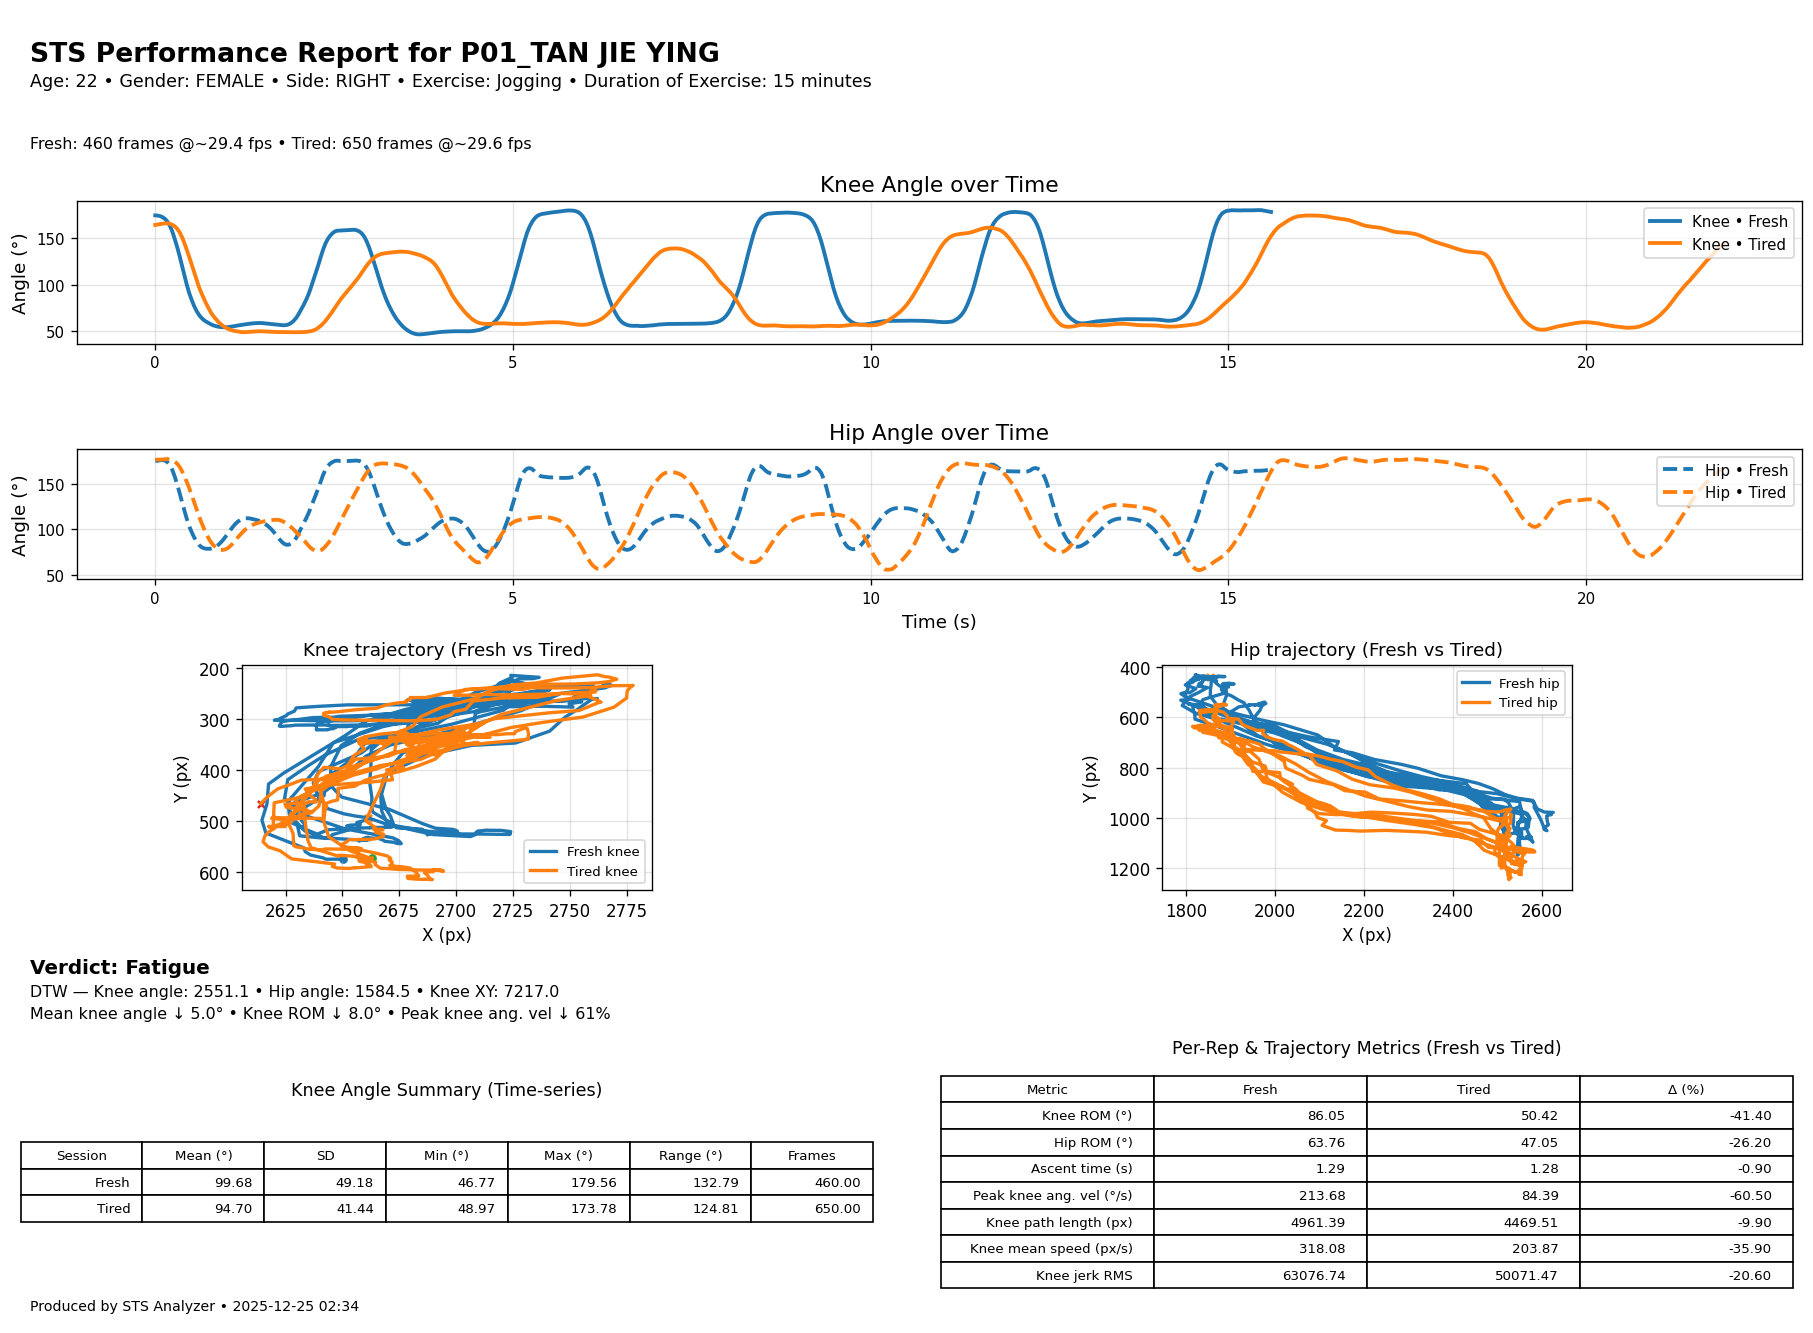


Report saved:
 - outputs\P01_TAN JIE YING\P01_TAN JIE YING_RIGHT_STS_report_20251225-023429.png
 - outputs\P01_TAN JIE YING\P01_TAN JIE YING_RIGHT_STS_report_20251225-023429.pdf


In [79]:
# Toggle: put legends outside to free space (set True to enable)
LEGENDS_OUTSIDE = False

# Bigger page + rebalanced rows to avoid overlaps
fig = plt.figure(figsize=(15, 11), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=7, ncols=4,
    #         title meta  time-series  XY row  verdict tables footer
    height_ratios=[0.7, 0.4, 6.2,      3.0,    1.0,   2.1,   0.3],
    width_ratios=[1,1,1,1]
)

# Title
ax_title = fig.add_subplot(gs[0, :]); ax_title.axis("off")
ax_title.text(0.01, 0.64, title, fontsize=16, weight="bold", ha="left")
ax_title.text(0.01, 0.34, subtitle, fontsize=10.5, ha="left")

# Meta
ax_meta = fig.add_subplot(gs[1, :]); ax_meta.axis("off")
ax_meta.text(0.01, 0.55,
             f"Fresh: {stats_f['n_frames']} frames @~{fps_f:.1f} fps • "
             f"Tired: {stats_t['n_frames']} frames @~{fps_t:.1f} fps",
             fontsize=9.5, ha="left")

# -------- Time-series (split: Knee top, Hip bottom) --------
# sensible y-limits from both sessions
knee_all = np.concatenate([df_fresh["knee_angle_smooth"].values,
                           df_tired["knee_angle_smooth"].values])
hip_all  = np.concatenate([df_fresh["hip_angle_smooth"].values,
                           df_tired["hip_angle_smooth"].values])

def expand_limits(arr, pad=10.0):
    lo, hi = np.nanmin(arr), np.nanmax(arr)
    return lo - pad, hi + pad

knee_ylim = expand_limits(knee_all)
hip_ylim  = expand_limits(hip_all)

# Use more vertical spacing between knee & hip
ts_grid = gs[2, :].subgridspec(
    2, 1,
    height_ratios=[1.1, 1.0],  # almost equal
    hspace=0.08                # MUCH less vertical gap
)

# --- Knee ---
ax_knee = fig.add_subplot(ts_grid[0, 0])
ax_knee.plot(df_fresh["time_s"], df_fresh["knee_angle_smooth"], label="Knee • Fresh", linewidth=2.3)
ax_knee.plot(df_tired["time_s"], df_tired["knee_angle_smooth"], label="Knee • Tired", linewidth=2.3)
ax_knee.set_ylabel("Angle (°)", fontsize=11)
ax_knee.set_title("Knee Angle over Time", fontsize=13, pad=6)
ax_knee.grid(True, alpha=0.35)
ax_knee.set_ylim(*knee_ylim)
ax_knee.tick_params(labelsize=9)
ax_knee.legend(loc="upper right", fontsize=9)

# --- Hip ---
ax_hip = fig.add_subplot(ts_grid[1, 0], sharex=ax_knee)
ax_hip.plot(df_fresh["time_s"], df_fresh["hip_angle_smooth"], label="Hip • Fresh",
            linewidth=2.3, linestyle="--")
ax_hip.plot(df_tired["time_s"], df_tired["hip_angle_smooth"], label="Hip • Tired",
            linewidth=2.3, linestyle="--")
ax_hip.set_xlabel("Time (s)", fontsize=11)
ax_hip.set_ylabel("Angle (°)", fontsize=11)
ax_hip.set_title("Hip Angle over Time", fontsize=13, pad=6)
ax_hip.grid(True, alpha=0.35)
ax_hip.set_ylim(*hip_ylim)
ax_hip.tick_params(labelsize=9)
ax_hip.legend(loc="upper right", fontsize=9)

# -------- XY trajectories (unchanged helpers) --------
ax_knee_xy = fig.add_subplot(gs[3, 0:2])
plot_xy_trajectories(df_fresh, df_tired, joint="knee", ax=ax_knee_xy,
                     title="Knee trajectory (Fresh vs Tired)", box_aspect=0.55)

ax_hip_xy = fig.add_subplot(gs[3, 2:4])
plot_xy_trajectories(df_fresh, df_tired, joint="hip", ax=ax_hip_xy,
                     title="Hip trajectory (Fresh vs Tired)", box_aspect=0.55)

# -------- Verdict (compact, no overlap) --------
ax_ver = fig.add_subplot(gs[4, :]); ax_ver.axis("off")
ax_ver.text(0.01, 0.75, f"Verdict: {verdict_ext}",
            fontsize=12, weight="bold", ha="left")
ax_ver.text(0.01, 0.45,
            f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} • "
            f"Hip angle: {dtw_angles['dtw_hip_angle']:.1f} • "
            f"Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}",
            fontsize=9.5, ha="left")
reasons_text = " • ".join(reasons_ext) if reasons_ext else "No thresholds exceeded."
if len(reasons_text) > 160:
    reasons_text = reasons_text[:157] + "…"
ax_ver.text(0.01, 0.15, reasons_text, fontsize=9.5, ha="left")

# -------- Tables (smaller fonts/scales) --------
ax_tbl1 = fig.add_subplot(gs[5, 0:2]); ax_tbl1.axis("off")
tbl1 = ax_tbl1.table(cellText=summary_df_fmt.values,
                     colLabels=summary_df_fmt.columns,
                     loc="center", cellLoc="right", colLoc="center")
tbl1.auto_set_font_size(False); tbl1.set_fontsize(8); tbl1.scale(0.98, 1.12)
ax_tbl1.set_title("Knee Angle Summary (Time-series)", fontsize=10.5, pad=5)

ax_tbl2 = fig.add_subplot(gs[5, 2:4]); ax_tbl2.axis("off")
tbl2 = ax_tbl2.table(cellText=derived_df_fmt.values,
                     colLabels=derived_df_fmt.columns,
                     loc="center", cellLoc="right", colLoc="center")
tbl2.auto_set_font_size(False); tbl2.set_fontsize(8); tbl2.scale(0.98, 1.12)
ax_tbl2.set_title("Per-Rep & Trajectory Metrics (Fresh vs Tired)\n\n", fontsize=10.5, pad=5)

# Footer
ax_foot = fig.add_subplot(gs[6, :]); ax_foot.axis("off")
ax_foot.text(0.01, 0.5, "Produced by STS Analyzer • " +
             pd.Timestamp.now().strftime("%Y-%m-%d %H:%M"),
             fontsize=8.5, ha="left")

plt.show()

# =========================
# SAVE (PNG + PDF)
# =========================
report_dir = Path("outputs") / p_name
report_dir.mkdir(parents=True, exist_ok=True)
stamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
png_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.png"
pdf_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.pdf"
fig.savefig(png_path, dpi=220, bbox_inches="tight")
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")
print(f"\nReport saved:\n - {png_path}\n - {pdf_path}")

# =========================
# Console summary (toggle)
# =========================
SHOW_CONSOLE = False
if SHOW_CONSOLE:
    print("\n===== Copy-ready Summary =====")
    print(f"Participant: {p_name} ({p_gender}, {p_age}) — Side: {SIDE}")
    print(summary_df_fmt.to_string(index=False))
    print("\nPer-rep/Trajectory (Fresh vs Tired, Δ%):")
    print(derived_df_fmt.to_string(index=False))
    print(f"\nVerdict (basic):   {verdict_basic}  | Reasons: {', '.join(reasons_basic) if reasons_basic else '-'}")
    print(f"Verdict (extended): {verdict_ext}  | Reasons: {', '.join(reasons_ext) if reasons_ext else '-'}")
    print(f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} | "
          f"Hip angle: {dtw_angles['dtw_hip_angle']:.1f} | "
          f"Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}")

# **Example Data**

### **1. P02_TAN ZHI EN**

In [80]:
fresh_video = r"P02_Fresh Squat.mov"
tired_video = r"P02_Tired Squat.mov"

SIDE = "LEFT"         # or "LEFT"
MA_WINDOW = 7          # 5–11 is typical

p_name   = "P02_TAN ZHI EN"
p_age    = "22"
p_gender = "MALE"
exercise_type = "Futsal"
exercise_duration = "2 hours"

# Define title and subtitle
title = f"\nSTS Performance Report for {p_name}\n"
subtitle = f"\nAge: {p_age} • Gender: {p_gender} • Side: {SIDE} • Exercise: {exercise_type} • Duration of Exercise: {exercise_duration}\n"

In [81]:
# 1) Extract per-frame data
df_fresh, fps_f = extract_angles_and_xy(fresh_video, SIDE, MA_WINDOW)
df_tired, fps_t = extract_angles_and_xy(tired_video, SIDE, MA_WINDOW)

# 2) Session stats
stats_f = quick_stats(df_fresh)
stats_t = quick_stats(df_tired)

# 3) Reps + per-rep features
reps_f = segment_reps(df_fresh, fps_f, min_separation_s=1.0)
reps_t = segment_reps(df_tired, fps_t, min_separation_s=1.0)
perrep_f = per_rep_features(df_fresh, reps_f) if len(reps_f) else pd.DataFrame()
perrep_t = per_rep_features(df_tired, reps_t) if len(reps_t) else pd.DataFrame()

# 4) Aggregates (fallback to session ROM if reps missing)
def agg_or_fallback(perrep_df, df_ts):
    if perrep_df.empty:
        agg = {
            "knee_ROM": float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5)),
            "hip_ROM":  float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5)),
            "ascent_time_s": np.nan,
            "descent_time_s": np.nan,
            "knee_peak_vel_deg_s": float(np.nanmax(np.abs(df_ts["knee_vel"])))
        }
    else:
        agg = perrep_df.mean(numeric_only=True).to_dict()
        if not np.isfinite(agg.get("knee_ROM", np.nan)):
            agg["knee_ROM"] = float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5))
        if not np.isfinite(agg.get("hip_ROM", np.nan)):
            agg["hip_ROM"]  = float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5))
    return agg

agg_f = agg_or_fallback(perrep_f, df_fresh)
agg_t = agg_or_fallback(perrep_t, df_tired)

# 5) Trajectory metrics
traj_f = trajectory_summary(df_fresh)
traj_t = trajectory_summary(df_tired)

# 6) DTW similarities
dtw_angles = dtw_compare_angles(df_fresh, df_tired, n=300)
dtw_kxy    = dtw_compare_knee_xy(df_fresh, df_tired, n=300)

# 7) Verdicts
verdict_basic, reasons_basic = simple_fatigue_flag(stats_f, stats_t)
verdict_ext,  reasons_ext    = fatigue_rule_extended(stats_f, stats_t, agg_f, agg_t)

# Helper formatters
def _fmt(x, nd=2):
    return "" if (x is None or (isinstance(x,float) and not np.isfinite(x))) else round(float(x), nd)
def _pct(f, t):
    if f is None or t is None or not np.isfinite(f) or not np.isfinite(t):
        return ""
    return round(100.0 * (t - f) / max(abs(f), 1e-6), 1)

# Tables (already formatted via format_df)
summary_df = pd.DataFrame([
    {"Session": "Fresh", "Mean (°)": round(stats_f["mean"], 2), "SD": round(stats_f["std"],2),
     "Min (°)": round(stats_f["min"],2), "Max (°)": round(stats_f["max"],2),
     "Range (°)": round(stats_f["range"],2), "Frames": stats_f["n_frames"]},
    {"Session": "Tired", "Mean (°)": round(stats_t["mean"], 2), "SD": round(stats_t["std"],2),
     "Min (°)": round(stats_t["min"],2), "Max (°)": round(stats_t["max"],2),
     "Range (°)": round(stats_t["range"],2), "Frames": stats_t["n_frames"]},
]).fillna("")
summary_df_fmt = format_df(summary_df, 2)

rows = []
rows.append(["Knee ROM (°)",            _fmt(agg_f.get("knee_ROM")),            _fmt(agg_t.get("knee_ROM")),            _pct(agg_f.get("knee_ROM"),            agg_t.get("knee_ROM"))])
rows.append(["Hip ROM (°)",             _fmt(agg_f.get("hip_ROM")),             _fmt(agg_t.get("hip_ROM")),             _pct(agg_f.get("hip_ROM"),             agg_t.get("hip_ROM"))])
rows.append(["Ascent time (s)",         _fmt(agg_f.get("ascent_time_s")),       _fmt(agg_t.get("ascent_time_s")),       _pct(agg_f.get("ascent_time_s"),       agg_t.get("ascent_time_s"))])
rows.append(["Peak knee ang. vel (°/s)",_fmt(agg_f.get("knee_peak_vel_deg_s")), _fmt(agg_t.get("knee_peak_vel_deg_s")), _pct(agg_f.get("knee_peak_vel_deg_s"), agg_t.get("knee_peak_vel_deg_s"))])
rows.append(["Knee path length (px)",   _fmt(traj_f.get("knee_path_len_px")),   _fmt(traj_t.get("knee_path_len_px")),   _pct(traj_f.get("knee_path_len_px"),   traj_t.get("knee_path_len_px"))])
rows.append(["Knee mean speed (px/s)",  _fmt(traj_f.get("knee_mean_speed_px_s")),_fmt(traj_t.get("knee_mean_speed_px_s")),_pct(traj_f.get("knee_mean_speed_px_s"),traj_t.get("knee_mean_speed_px_s"))])
rows.append(["Knee jerk RMS",           _fmt(traj_f.get("knee_jerk_rms")),      _fmt(traj_t.get("knee_jerk_rms")),      _pct(traj_f.get("knee_jerk_rms"),      traj_t.get("knee_jerk_rms"))])

derived_df = pd.DataFrame(rows, columns=["Metric", "Fresh", "Tired", "Δ (%)"])
derived_df = derived_df.replace("", np.nan).dropna(how="all").fillna("")
derived_df_fmt = format_df(derived_df, 2)

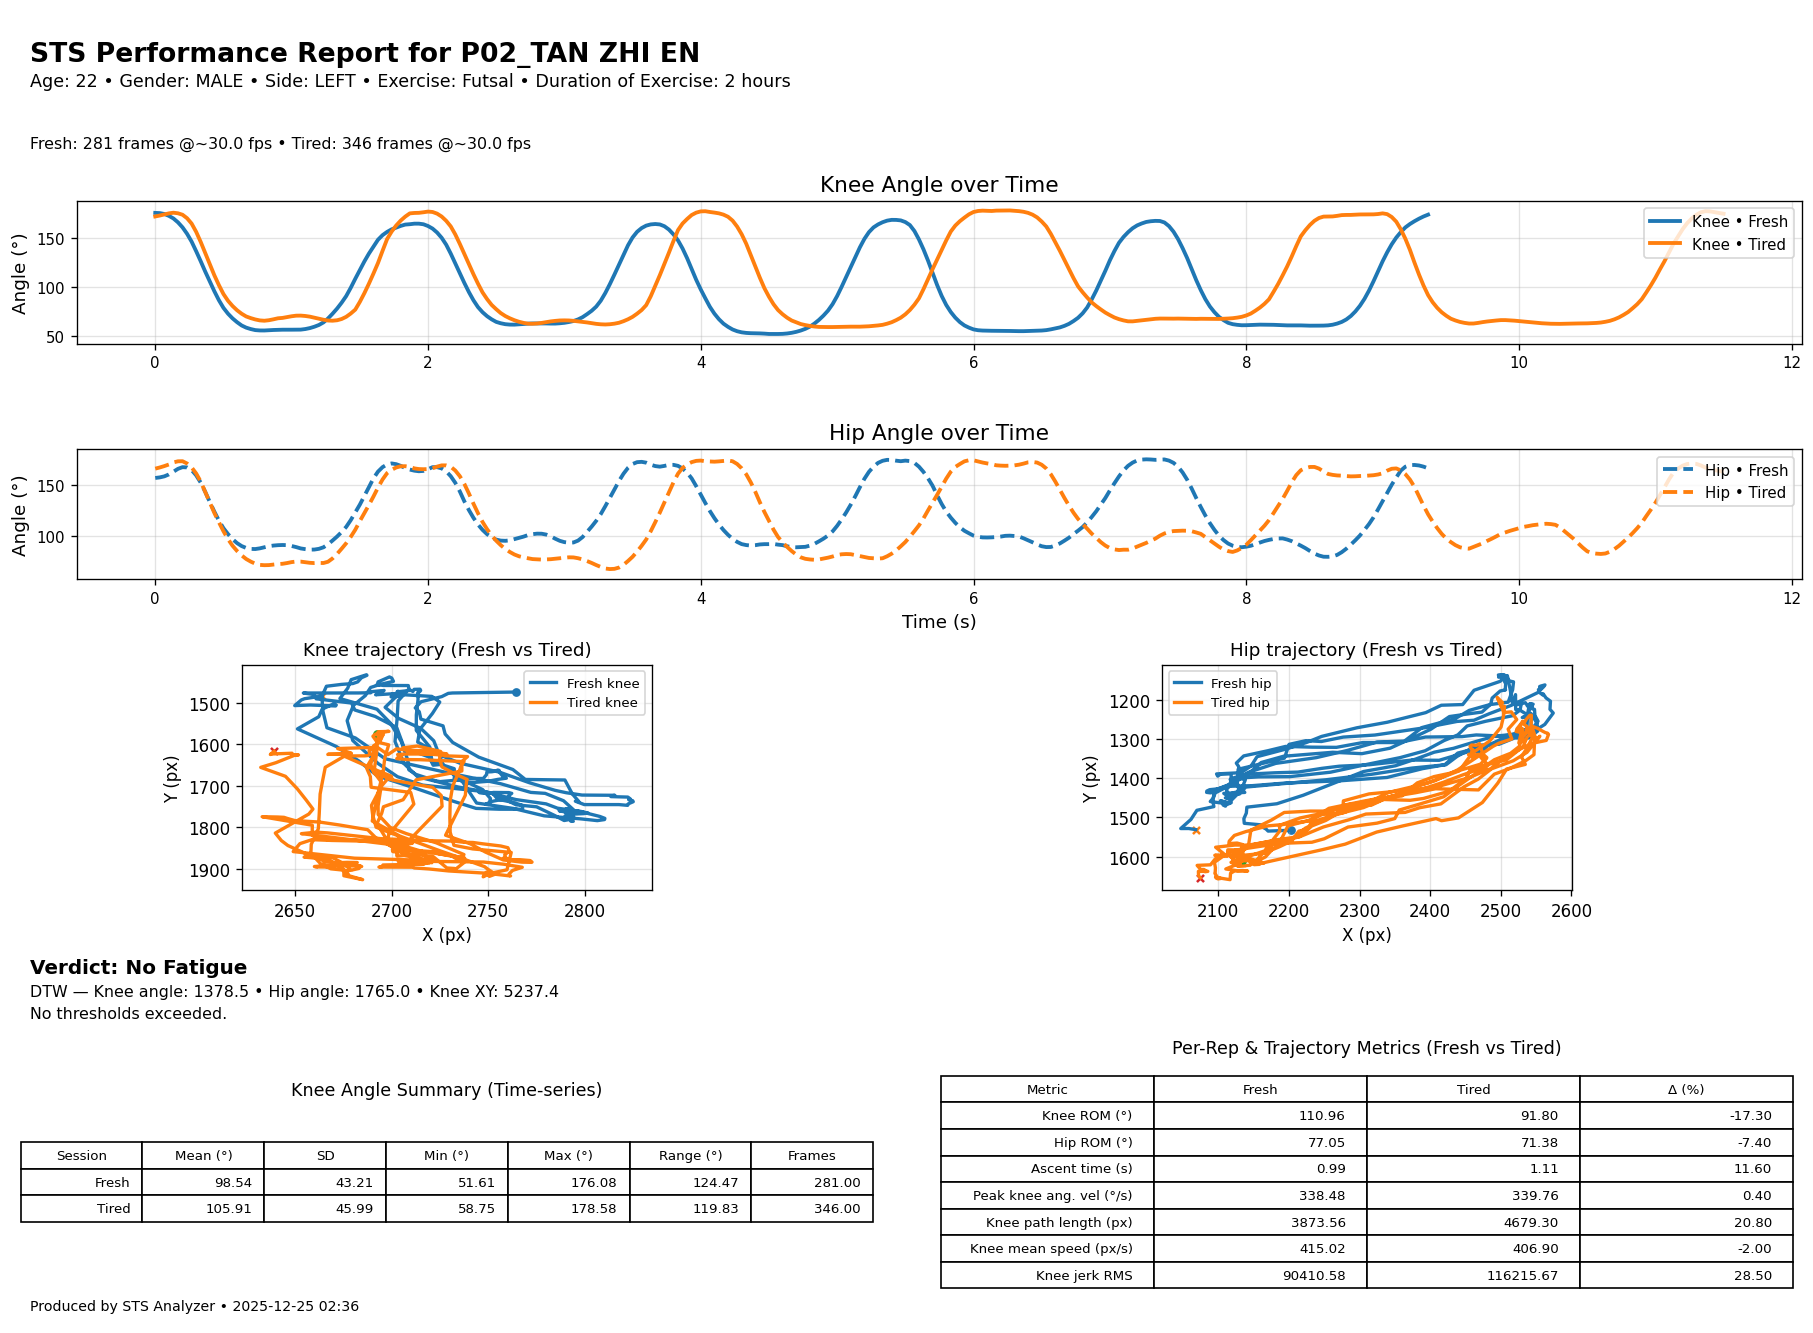


Report saved:
 - outputs\P02_TAN ZHI EN\P02_TAN ZHI EN_LEFT_STS_report_20251225-023633.png
 - outputs\P02_TAN ZHI EN\P02_TAN ZHI EN_LEFT_STS_report_20251225-023633.pdf


In [82]:
# Toggle: put legends outside to free space (set True to enable)
LEGENDS_OUTSIDE = False

# Bigger page + rebalanced rows to avoid overlaps
fig = plt.figure(figsize=(15, 11), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=7, ncols=4,
    #         title meta  time-series  XY row  verdict tables footer
    height_ratios=[0.7, 0.4, 6.2,      3.0,    1.0,   2.1,   0.3],
    width_ratios=[1,1,1,1]
)

# Title
ax_title = fig.add_subplot(gs[0, :]); ax_title.axis("off")
ax_title.text(0.01, 0.64, title, fontsize=16, weight="bold", ha="left")
ax_title.text(0.01, 0.34, subtitle, fontsize=10.5, ha="left")

# Meta
ax_meta = fig.add_subplot(gs[1, :]); ax_meta.axis("off")
ax_meta.text(0.01, 0.55,
             f"Fresh: {stats_f['n_frames']} frames @~{fps_f:.1f} fps • "
             f"Tired: {stats_t['n_frames']} frames @~{fps_t:.1f} fps",
             fontsize=9.5, ha="left")

# -------- Time-series (split: Knee top, Hip bottom) --------
# sensible y-limits from both sessions
knee_all = np.concatenate([df_fresh["knee_angle_smooth"].values,
                           df_tired["knee_angle_smooth"].values])
hip_all  = np.concatenate([df_fresh["hip_angle_smooth"].values,
                           df_tired["hip_angle_smooth"].values])

def expand_limits(arr, pad=10.0):
    lo, hi = np.nanmin(arr), np.nanmax(arr)
    return lo - pad, hi + pad

knee_ylim = expand_limits(knee_all)
hip_ylim  = expand_limits(hip_all)

# Use more vertical spacing between knee & hip
ts_grid = gs[2, :].subgridspec(
    2, 1,
    height_ratios=[1.1, 1.0],  # almost equal
    hspace=0.08                # MUCH less vertical gap
)

# --- Knee ---
ax_knee = fig.add_subplot(ts_grid[0, 0])
ax_knee.plot(df_fresh["time_s"], df_fresh["knee_angle_smooth"], label="Knee • Fresh", linewidth=2.3)
ax_knee.plot(df_tired["time_s"], df_tired["knee_angle_smooth"], label="Knee • Tired", linewidth=2.3)
ax_knee.set_ylabel("Angle (°)", fontsize=11)
ax_knee.set_title("Knee Angle over Time", fontsize=13, pad=6)
ax_knee.grid(True, alpha=0.35)
ax_knee.set_ylim(*knee_ylim)
ax_knee.tick_params(labelsize=9)
ax_knee.legend(loc="upper right", fontsize=9)

# --- Hip ---
ax_hip = fig.add_subplot(ts_grid[1, 0], sharex=ax_knee)
ax_hip.plot(df_fresh["time_s"], df_fresh["hip_angle_smooth"], label="Hip • Fresh",
            linewidth=2.3, linestyle="--")
ax_hip.plot(df_tired["time_s"], df_tired["hip_angle_smooth"], label="Hip • Tired",
            linewidth=2.3, linestyle="--")
ax_hip.set_xlabel("Time (s)", fontsize=11)
ax_hip.set_ylabel("Angle (°)", fontsize=11)
ax_hip.set_title("Hip Angle over Time", fontsize=13, pad=6)
ax_hip.grid(True, alpha=0.35)
ax_hip.set_ylim(*hip_ylim)
ax_hip.tick_params(labelsize=9)
ax_hip.legend(loc="upper right", fontsize=9)

# -------- XY trajectories (unchanged helpers) --------
ax_knee_xy = fig.add_subplot(gs[3, 0:2])
plot_xy_trajectories(df_fresh, df_tired, joint="knee", ax=ax_knee_xy,
                     title="Knee trajectory (Fresh vs Tired)", box_aspect=0.55)

ax_hip_xy = fig.add_subplot(gs[3, 2:4])
plot_xy_trajectories(df_fresh, df_tired, joint="hip", ax=ax_hip_xy,
                     title="Hip trajectory (Fresh vs Tired)", box_aspect=0.55)

# -------- Verdict (compact, no overlap) --------
ax_ver = fig.add_subplot(gs[4, :]); ax_ver.axis("off")
ax_ver.text(0.01, 0.75, f"Verdict: {verdict_ext}",
            fontsize=12, weight="bold", ha="left")
ax_ver.text(0.01, 0.45,
            f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} • "
            f"Hip angle: {dtw_angles['dtw_hip_angle']:.1f} • "
            f"Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}",
            fontsize=9.5, ha="left")
reasons_text = " • ".join(reasons_ext) if reasons_ext else "No thresholds exceeded."
if len(reasons_text) > 160:
    reasons_text = reasons_text[:157] + "…"
ax_ver.text(0.01, 0.15, reasons_text, fontsize=9.5, ha="left")

# -------- Tables (smaller fonts/scales) --------
ax_tbl1 = fig.add_subplot(gs[5, 0:2]); ax_tbl1.axis("off")
tbl1 = ax_tbl1.table(cellText=summary_df_fmt.values,
                     colLabels=summary_df_fmt.columns,
                     loc="center", cellLoc="right", colLoc="center")
tbl1.auto_set_font_size(False); tbl1.set_fontsize(8); tbl1.scale(0.98, 1.12)
ax_tbl1.set_title("Knee Angle Summary (Time-series)", fontsize=10.5, pad=5)

ax_tbl2 = fig.add_subplot(gs[5, 2:4]); ax_tbl2.axis("off")
tbl2 = ax_tbl2.table(cellText=derived_df_fmt.values,
                     colLabels=derived_df_fmt.columns,
                     loc="center", cellLoc="right", colLoc="center")
tbl2.auto_set_font_size(False); tbl2.set_fontsize(8); tbl2.scale(0.98, 1.12)
ax_tbl2.set_title("Per-Rep & Trajectory Metrics (Fresh vs Tired)\n\n", fontsize=10.5, pad=5)

# Footer
ax_foot = fig.add_subplot(gs[6, :]); ax_foot.axis("off")
ax_foot.text(0.01, 0.5, "Produced by STS Analyzer • " +
             pd.Timestamp.now().strftime("%Y-%m-%d %H:%M"),
             fontsize=8.5, ha="left")

plt.show()

# =========================
# SAVE (PNG + PDF)
# =========================
report_dir = Path("outputs") / p_name
report_dir.mkdir(parents=True, exist_ok=True)
stamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
png_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.png"
pdf_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.pdf"
fig.savefig(png_path, dpi=220, bbox_inches="tight")
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")
print(f"\nReport saved:\n - {png_path}\n - {pdf_path}")

# =========================
# Console summary (toggle)
# =========================
SHOW_CONSOLE = False
if SHOW_CONSOLE:
    print("\n===== Copy-ready Summary =====")
    print(f"Participant: {p_name} ({p_gender}, {p_age}) — Side: {SIDE}")
    print(summary_df_fmt.to_string(index=False))
    print("\nPer-rep/Trajectory (Fresh vs Tired, Δ%):")
    print(derived_df_fmt.to_string(index=False))
    print(f"\nVerdict (basic):   {verdict_basic}  | Reasons: {', '.join(reasons_basic) if reasons_basic else '-'}")
    print(f"Verdict (extended): {verdict_ext}  | Reasons: {', '.join(reasons_ext) if reasons_ext else '-'}")
    print(f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} | "
          f"Hip angle: {dtw_angles['dtw_hip_angle']:.1f} | "
          f"Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}")

### **2. P03_TAN SWEE AUN**

In [83]:
fresh_video = r"P03_Fresh Squat.mov"
tired_video = r"P03_Tired Squat.mov"

SIDE = "LEFT"         # or "LEFT"
MA_WINDOW = 7          # 5–11 is typical

p_name   = "P03_TAN SWEE AUN"
p_age    = "56"
p_gender = "MALE"
exercise_type = "Badminton"
exercise_duration = "1 hour"

# Define title and subtitle
title = f"\nSTS Performance Report for {p_name}\n"
subtitle = f"\nAge: {p_age} • Gender: {p_gender} • Side: {SIDE} • Exercise: {exercise_type} • Duration of Exercise: {exercise_duration}\n"

In [84]:
# 1) Extract per-frame data
df_fresh, fps_f = extract_angles_and_xy(fresh_video, SIDE, MA_WINDOW)
df_tired, fps_t = extract_angles_and_xy(tired_video, SIDE, MA_WINDOW)

# 2) Session stats
stats_f = quick_stats(df_fresh)
stats_t = quick_stats(df_tired)

# 3) Reps + per-rep features
reps_f = segment_reps(df_fresh, fps_f, min_separation_s=1.0)
reps_t = segment_reps(df_tired, fps_t, min_separation_s=1.0)
perrep_f = per_rep_features(df_fresh, reps_f) if len(reps_f) else pd.DataFrame()
perrep_t = per_rep_features(df_tired, reps_t) if len(reps_t) else pd.DataFrame()

# 4) Aggregates (fallback to session ROM if reps missing)
def agg_or_fallback(perrep_df, df_ts):
    if perrep_df.empty:
        agg = {
            "knee_ROM": float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5)),
            "hip_ROM":  float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5)),
            "ascent_time_s": np.nan,
            "descent_time_s": np.nan,
            "knee_peak_vel_deg_s": float(np.nanmax(np.abs(df_ts["knee_vel"])))
        }
    else:
        agg = perrep_df.mean(numeric_only=True).to_dict()
        if not np.isfinite(agg.get("knee_ROM", np.nan)):
            agg["knee_ROM"] = float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5))
        if not np.isfinite(agg.get("hip_ROM", np.nan)):
            agg["hip_ROM"]  = float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5))
    return agg

agg_f = agg_or_fallback(perrep_f, df_fresh)
agg_t = agg_or_fallback(perrep_t, df_tired)

# 5) Trajectory metrics
traj_f = trajectory_summary(df_fresh)
traj_t = trajectory_summary(df_tired)

# 6) DTW similarities
dtw_angles = dtw_compare_angles(df_fresh, df_tired, n=300)
dtw_kxy    = dtw_compare_knee_xy(df_fresh, df_tired, n=300)

# 7) Verdicts
verdict_basic, reasons_basic = simple_fatigue_flag(stats_f, stats_t)
verdict_ext,  reasons_ext    = fatigue_rule_extended(stats_f, stats_t, agg_f, agg_t)

# Helper formatters
def _fmt(x, nd=2):
    return "" if (x is None or (isinstance(x,float) and not np.isfinite(x))) else round(float(x), nd)
def _pct(f, t):
    if f is None or t is None or not np.isfinite(f) or not np.isfinite(t):
        return ""
    return round(100.0 * (t - f) / max(abs(f), 1e-6), 1)

# Tables (already formatted via format_df)
summary_df = pd.DataFrame([
    {"Session": "Fresh", "Mean (°)": round(stats_f["mean"], 2), "SD": round(stats_f["std"],2),
     "Min (°)": round(stats_f["min"],2), "Max (°)": round(stats_f["max"],2),
     "Range (°)": round(stats_f["range"],2), "Frames": stats_f["n_frames"]},
    {"Session": "Tired", "Mean (°)": round(stats_t["mean"], 2), "SD": round(stats_t["std"],2),
     "Min (°)": round(stats_t["min"],2), "Max (°)": round(stats_t["max"],2),
     "Range (°)": round(stats_t["range"],2), "Frames": stats_t["n_frames"]},
]).fillna("")
summary_df_fmt = format_df(summary_df, 2)

rows = []
rows.append(["Knee ROM (°)",            _fmt(agg_f.get("knee_ROM")),            _fmt(agg_t.get("knee_ROM")),            _pct(agg_f.get("knee_ROM"),            agg_t.get("knee_ROM"))])
rows.append(["Hip ROM (°)",             _fmt(agg_f.get("hip_ROM")),             _fmt(agg_t.get("hip_ROM")),             _pct(agg_f.get("hip_ROM"),             agg_t.get("hip_ROM"))])
rows.append(["Ascent time (s)",         _fmt(agg_f.get("ascent_time_s")),       _fmt(agg_t.get("ascent_time_s")),       _pct(agg_f.get("ascent_time_s"),       agg_t.get("ascent_time_s"))])
rows.append(["Peak knee ang. vel (°/s)",_fmt(agg_f.get("knee_peak_vel_deg_s")), _fmt(agg_t.get("knee_peak_vel_deg_s")), _pct(agg_f.get("knee_peak_vel_deg_s"), agg_t.get("knee_peak_vel_deg_s"))])
rows.append(["Knee path length (px)",   _fmt(traj_f.get("knee_path_len_px")),   _fmt(traj_t.get("knee_path_len_px")),   _pct(traj_f.get("knee_path_len_px"),   traj_t.get("knee_path_len_px"))])
rows.append(["Knee mean speed (px/s)",  _fmt(traj_f.get("knee_mean_speed_px_s")),_fmt(traj_t.get("knee_mean_speed_px_s")),_pct(traj_f.get("knee_mean_speed_px_s"),traj_t.get("knee_mean_speed_px_s"))])
rows.append(["Knee jerk RMS",           _fmt(traj_f.get("knee_jerk_rms")),      _fmt(traj_t.get("knee_jerk_rms")),      _pct(traj_f.get("knee_jerk_rms"),      traj_t.get("knee_jerk_rms"))])

derived_df = pd.DataFrame(rows, columns=["Metric", "Fresh", "Tired", "Δ (%)"])
derived_df = derived_df.replace("", np.nan).dropna(how="all").fillna("")
derived_df_fmt = format_df(derived_df, 2)

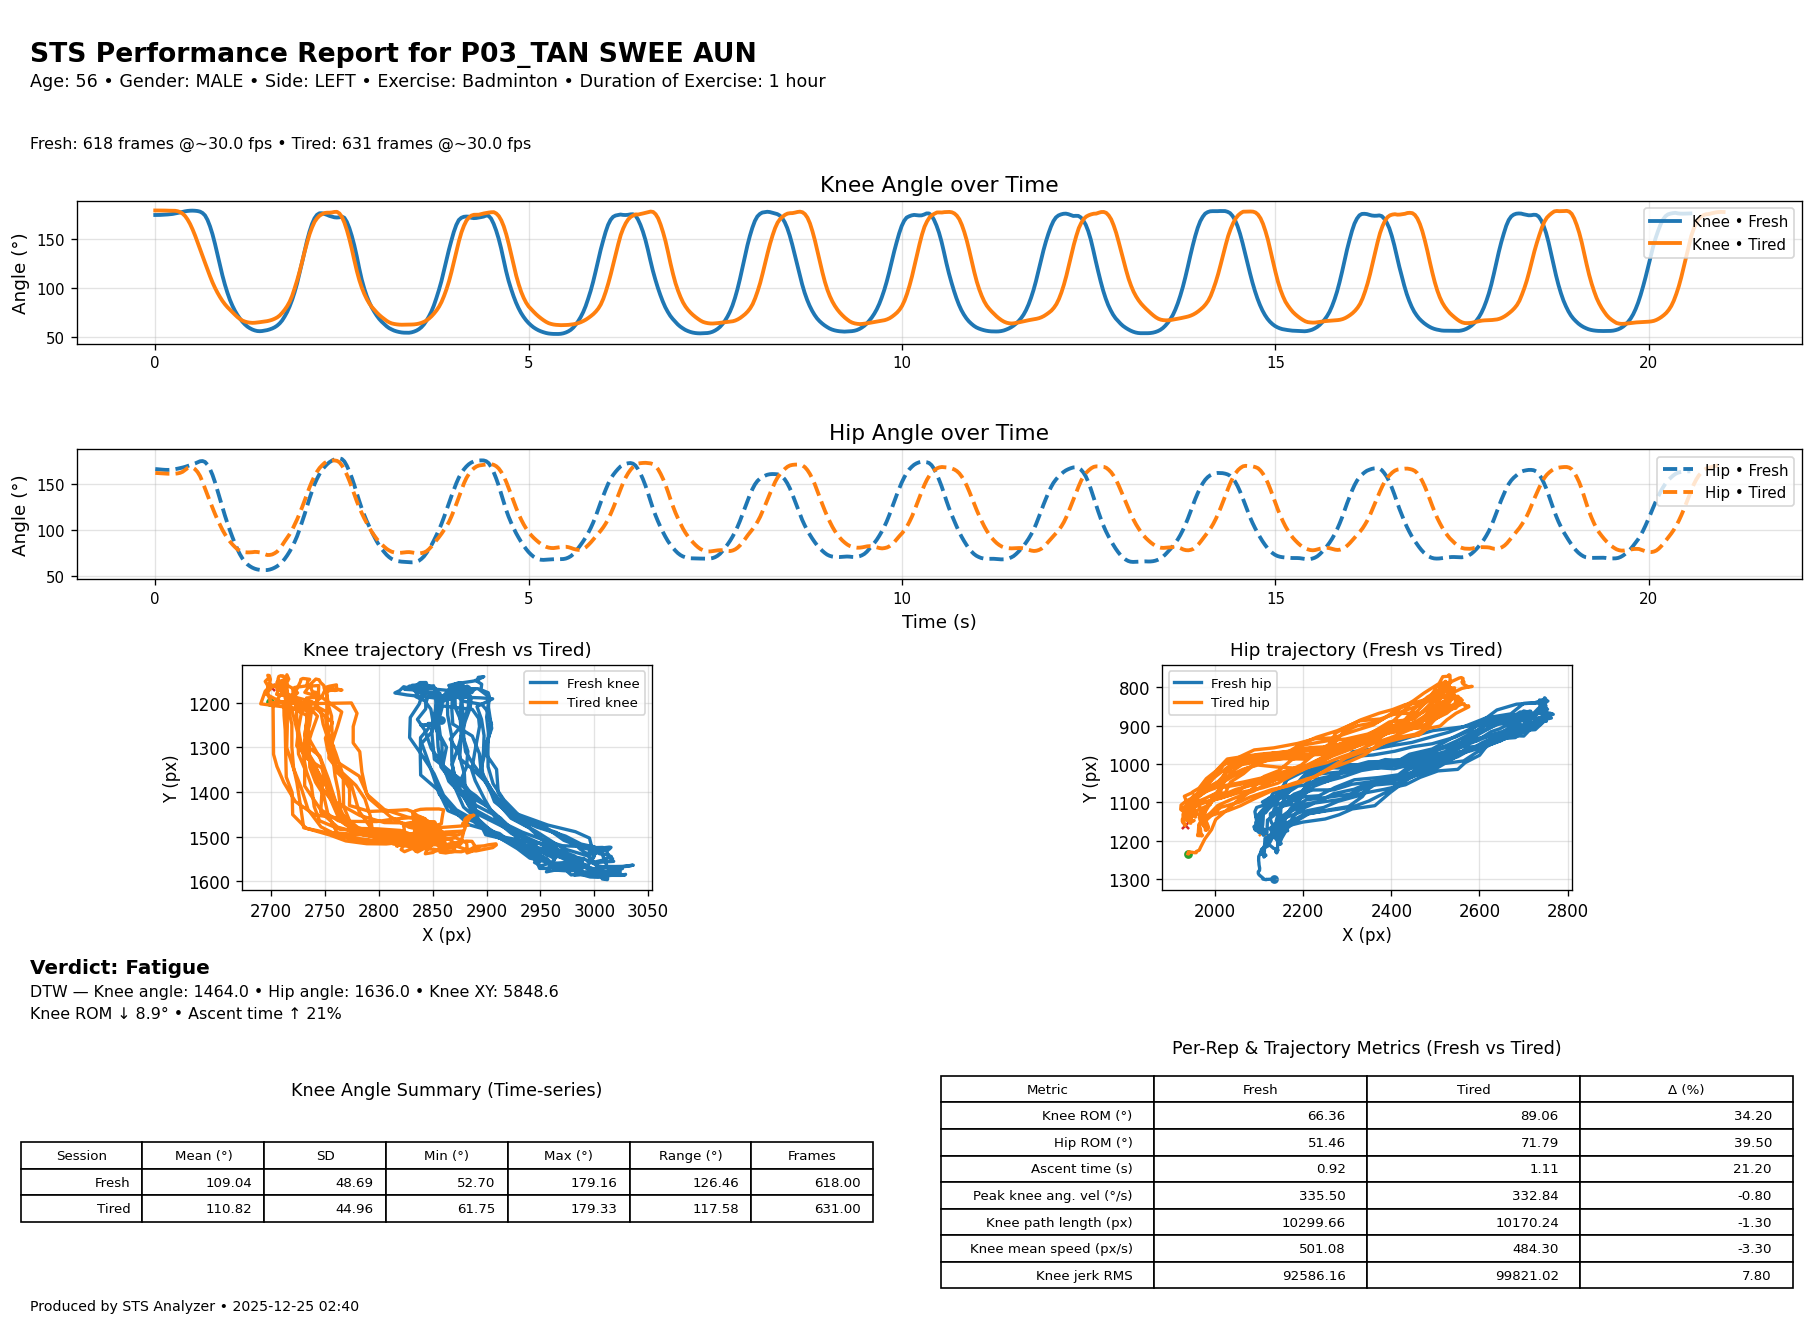


Report saved:
 - outputs\P03_TAN SWEE AUN\P03_TAN SWEE AUN_LEFT_STS_report_20251225-024005.png
 - outputs\P03_TAN SWEE AUN\P03_TAN SWEE AUN_LEFT_STS_report_20251225-024005.pdf


In [85]:
# Toggle: put legends outside to free space (set True to enable)
LEGENDS_OUTSIDE = False

# Bigger page + rebalanced rows to avoid overlaps
fig = plt.figure(figsize=(15, 11), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=7, ncols=4,
    #         title meta  time-series  XY row  verdict tables footer
    height_ratios=[0.7, 0.4, 6.2,      3.0,    1.0,   2.1,   0.3],
    width_ratios=[1,1,1,1]
)

# Title
ax_title = fig.add_subplot(gs[0, :]); ax_title.axis("off")
ax_title.text(0.01, 0.64, title, fontsize=16, weight="bold", ha="left")
ax_title.text(0.01, 0.34, subtitle, fontsize=10.5, ha="left")

# Meta
ax_meta = fig.add_subplot(gs[1, :]); ax_meta.axis("off")
ax_meta.text(0.01, 0.55,
             f"Fresh: {stats_f['n_frames']} frames @~{fps_f:.1f} fps • "
             f"Tired: {stats_t['n_frames']} frames @~{fps_t:.1f} fps",
             fontsize=9.5, ha="left")

# -------- Time-series (split: Knee top, Hip bottom) --------
# sensible y-limits from both sessions
knee_all = np.concatenate([df_fresh["knee_angle_smooth"].values,
                           df_tired["knee_angle_smooth"].values])
hip_all  = np.concatenate([df_fresh["hip_angle_smooth"].values,
                           df_tired["hip_angle_smooth"].values])

def expand_limits(arr, pad=10.0):
    lo, hi = np.nanmin(arr), np.nanmax(arr)
    return lo - pad, hi + pad

knee_ylim = expand_limits(knee_all)
hip_ylim  = expand_limits(hip_all)

# Use more vertical spacing between knee & hip
ts_grid = gs[2, :].subgridspec(
    2, 1,
    height_ratios=[1.1, 1.0],  # almost equal
    hspace=0.08                # MUCH less vertical gap
)

# --- Knee ---
ax_knee = fig.add_subplot(ts_grid[0, 0])
ax_knee.plot(df_fresh["time_s"], df_fresh["knee_angle_smooth"], label="Knee • Fresh", linewidth=2.3)
ax_knee.plot(df_tired["time_s"], df_tired["knee_angle_smooth"], label="Knee • Tired", linewidth=2.3)
ax_knee.set_ylabel("Angle (°)", fontsize=11)
ax_knee.set_title("Knee Angle over Time", fontsize=13, pad=6)
ax_knee.grid(True, alpha=0.35)
ax_knee.set_ylim(*knee_ylim)
ax_knee.tick_params(labelsize=9)
ax_knee.legend(loc="upper right", fontsize=9)

# --- Hip ---
ax_hip = fig.add_subplot(ts_grid[1, 0], sharex=ax_knee)
ax_hip.plot(df_fresh["time_s"], df_fresh["hip_angle_smooth"], label="Hip • Fresh",
            linewidth=2.3, linestyle="--")
ax_hip.plot(df_tired["time_s"], df_tired["hip_angle_smooth"], label="Hip • Tired",
            linewidth=2.3, linestyle="--")
ax_hip.set_xlabel("Time (s)", fontsize=11)
ax_hip.set_ylabel("Angle (°)", fontsize=11)
ax_hip.set_title("Hip Angle over Time", fontsize=13, pad=6)
ax_hip.grid(True, alpha=0.35)
ax_hip.set_ylim(*hip_ylim)
ax_hip.tick_params(labelsize=9)
ax_hip.legend(loc="upper right", fontsize=9)

# -------- XY trajectories (unchanged helpers) --------
ax_knee_xy = fig.add_subplot(gs[3, 0:2])
plot_xy_trajectories(df_fresh, df_tired, joint="knee", ax=ax_knee_xy,
                     title="Knee trajectory (Fresh vs Tired)", box_aspect=0.55)

ax_hip_xy = fig.add_subplot(gs[3, 2:4])
plot_xy_trajectories(df_fresh, df_tired, joint="hip", ax=ax_hip_xy,
                     title="Hip trajectory (Fresh vs Tired)", box_aspect=0.55)

# -------- Verdict (compact, no overlap) --------
ax_ver = fig.add_subplot(gs[4, :]); ax_ver.axis("off")
ax_ver.text(0.01, 0.75, f"Verdict: {verdict_ext}",
            fontsize=12, weight="bold", ha="left")
ax_ver.text(0.01, 0.45,
            f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} • "
            f"Hip angle: {dtw_angles['dtw_hip_angle']:.1f} • "
            f"Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}",
            fontsize=9.5, ha="left")
reasons_text = " • ".join(reasons_ext) if reasons_ext else "No thresholds exceeded."
if len(reasons_text) > 160:
    reasons_text = reasons_text[:157] + "…"
ax_ver.text(0.01, 0.15, reasons_text, fontsize=9.5, ha="left")

# -------- Tables (smaller fonts/scales) --------
ax_tbl1 = fig.add_subplot(gs[5, 0:2]); ax_tbl1.axis("off")
tbl1 = ax_tbl1.table(cellText=summary_df_fmt.values,
                     colLabels=summary_df_fmt.columns,
                     loc="center", cellLoc="right", colLoc="center")
tbl1.auto_set_font_size(False); tbl1.set_fontsize(8); tbl1.scale(0.98, 1.12)
ax_tbl1.set_title("Knee Angle Summary (Time-series)", fontsize=10.5, pad=5)

ax_tbl2 = fig.add_subplot(gs[5, 2:4]); ax_tbl2.axis("off")
tbl2 = ax_tbl2.table(cellText=derived_df_fmt.values,
                     colLabels=derived_df_fmt.columns,
                     loc="center", cellLoc="right", colLoc="center")
tbl2.auto_set_font_size(False); tbl2.set_fontsize(8); tbl2.scale(0.98, 1.12)
ax_tbl2.set_title("Per-Rep & Trajectory Metrics (Fresh vs Tired)\n\n", fontsize=10.5, pad=5)

# Footer
ax_foot = fig.add_subplot(gs[6, :]); ax_foot.axis("off")
ax_foot.text(0.01, 0.5, "Produced by STS Analyzer • " +
             pd.Timestamp.now().strftime("%Y-%m-%d %H:%M"),
             fontsize=8.5, ha="left")

plt.show()

# =========================
# SAVE (PNG + PDF)
# =========================
report_dir = Path("outputs") / p_name
report_dir.mkdir(parents=True, exist_ok=True)
stamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
png_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.png"
pdf_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.pdf"
fig.savefig(png_path, dpi=220, bbox_inches="tight")
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")
print(f"\nReport saved:\n - {png_path}\n - {pdf_path}")

# =========================
# Console summary (toggle)
# =========================
SHOW_CONSOLE = False
if SHOW_CONSOLE:
    print("\n===== Copy-ready Summary =====")
    print(f"Participant: {p_name} ({p_gender}, {p_age}) — Side: {SIDE}")
    print(summary_df_fmt.to_string(index=False))
    print("\nPer-rep/Trajectory (Fresh vs Tired, Δ%):")
    print(derived_df_fmt.to_string(index=False))
    print(f"\nVerdict (basic):   {verdict_basic}  | Reasons: {', '.join(reasons_basic) if reasons_basic else '-'}")
    print(f"Verdict (extended): {verdict_ext}  | Reasons: {', '.join(reasons_ext) if reasons_ext else '-'}")
    print(f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} | "
          f"Hip angle: {dtw_angles['dtw_hip_angle']:.1f} | "
          f"Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}")

### **3. P04_TAN ZHI JIE**

In [86]:
fresh_video = r"P04_Fresh Squat.mov"
tired_video = r"P04_Tired Squat.mov"

SIDE = "LEFT"         # or "LEFT"
MA_WINDOW = 7          # 5–11 is typical

p_name   = "P04_TAN ZHI JIE"
p_age    = "20"
p_gender = "MALE"
exercise_type = "Badminton"
exercise_duration = "1 hour"

# Define title and subtitle
title = f"\nSTS Performance Report for {p_name}\n"
subtitle = f"\nAge: {p_age} • Gender: {p_gender} • Side: {SIDE} • Exercise: {exercise_type} • Duration of Exercise: {exercise_duration}\n"

In [87]:
# 1) Extract per-frame data
df_fresh, fps_f = extract_angles_and_xy(fresh_video, SIDE, MA_WINDOW)
df_tired, fps_t = extract_angles_and_xy(tired_video, SIDE, MA_WINDOW)

# 2) Session stats
stats_f = quick_stats(df_fresh)
stats_t = quick_stats(df_tired)

# 3) Reps + per-rep features
reps_f = segment_reps(df_fresh, fps_f, min_separation_s=1.0)
reps_t = segment_reps(df_tired, fps_t, min_separation_s=1.0)
perrep_f = per_rep_features(df_fresh, reps_f) if len(reps_f) else pd.DataFrame()
perrep_t = per_rep_features(df_tired, reps_t) if len(reps_t) else pd.DataFrame()

# 4) Aggregates (fallback to session ROM if reps missing)
def agg_or_fallback(perrep_df, df_ts):
    if perrep_df.empty:
        agg = {
            "knee_ROM": float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5)),
            "hip_ROM":  float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5)),
            "ascent_time_s": np.nan,
            "descent_time_s": np.nan,
            "knee_peak_vel_deg_s": float(np.nanmax(np.abs(df_ts["knee_vel"])))
        }
    else:
        agg = perrep_df.mean(numeric_only=True).to_dict()
        if not np.isfinite(agg.get("knee_ROM", np.nan)):
            agg["knee_ROM"] = float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5))
        if not np.isfinite(agg.get("hip_ROM", np.nan)):
            agg["hip_ROM"]  = float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5))
    return agg

agg_f = agg_or_fallback(perrep_f, df_fresh)
agg_t = agg_or_fallback(perrep_t, df_tired)

# 5) Trajectory metrics
traj_f = trajectory_summary(df_fresh)
traj_t = trajectory_summary(df_tired)

# 6) DTW similarities
dtw_angles = dtw_compare_angles(df_fresh, df_tired, n=300)
dtw_kxy    = dtw_compare_knee_xy(df_fresh, df_tired, n=300)

# 7) Verdicts
verdict_basic, reasons_basic = simple_fatigue_flag(stats_f, stats_t)
verdict_ext,  reasons_ext    = fatigue_rule_extended(stats_f, stats_t, agg_f, agg_t)

# Helper formatters
def _fmt(x, nd=2):
    return "" if (x is None or (isinstance(x,float) and not np.isfinite(x))) else round(float(x), nd)
def _pct(f, t):
    if f is None or t is None or not np.isfinite(f) or not np.isfinite(t):
        return ""
    return round(100.0 * (t - f) / max(abs(f), 1e-6), 1)

# Tables (already formatted via format_df)
summary_df = pd.DataFrame([
    {"Session": "Fresh", "Mean (°)": round(stats_f["mean"], 2), "SD": round(stats_f["std"],2),
     "Min (°)": round(stats_f["min"],2), "Max (°)": round(stats_f["max"],2),
     "Range (°)": round(stats_f["range"],2), "Frames": stats_f["n_frames"]},
    {"Session": "Tired", "Mean (°)": round(stats_t["mean"], 2), "SD": round(stats_t["std"],2),
     "Min (°)": round(stats_t["min"],2), "Max (°)": round(stats_t["max"],2),
     "Range (°)": round(stats_t["range"],2), "Frames": stats_t["n_frames"]},
]).fillna("")
summary_df_fmt = format_df(summary_df, 2)

rows = []
rows.append(["Knee ROM (°)",            _fmt(agg_f.get("knee_ROM")),            _fmt(agg_t.get("knee_ROM")),            _pct(agg_f.get("knee_ROM"),            agg_t.get("knee_ROM"))])
rows.append(["Hip ROM (°)",             _fmt(agg_f.get("hip_ROM")),             _fmt(agg_t.get("hip_ROM")),             _pct(agg_f.get("hip_ROM"),             agg_t.get("hip_ROM"))])
rows.append(["Ascent time (s)",         _fmt(agg_f.get("ascent_time_s")),       _fmt(agg_t.get("ascent_time_s")),       _pct(agg_f.get("ascent_time_s"),       agg_t.get("ascent_time_s"))])
rows.append(["Peak knee ang. vel (°/s)",_fmt(agg_f.get("knee_peak_vel_deg_s")), _fmt(agg_t.get("knee_peak_vel_deg_s")), _pct(agg_f.get("knee_peak_vel_deg_s"), agg_t.get("knee_peak_vel_deg_s"))])
rows.append(["Knee path length (px)",   _fmt(traj_f.get("knee_path_len_px")),   _fmt(traj_t.get("knee_path_len_px")),   _pct(traj_f.get("knee_path_len_px"),   traj_t.get("knee_path_len_px"))])
rows.append(["Knee mean speed (px/s)",  _fmt(traj_f.get("knee_mean_speed_px_s")),_fmt(traj_t.get("knee_mean_speed_px_s")),_pct(traj_f.get("knee_mean_speed_px_s"),traj_t.get("knee_mean_speed_px_s"))])
rows.append(["Knee jerk RMS",           _fmt(traj_f.get("knee_jerk_rms")),      _fmt(traj_t.get("knee_jerk_rms")),      _pct(traj_f.get("knee_jerk_rms"),      traj_t.get("knee_jerk_rms"))])

derived_df = pd.DataFrame(rows, columns=["Metric", "Fresh", "Tired", "Δ (%)"])
derived_df = derived_df.replace("", np.nan).dropna(how="all").fillna("")
derived_df_fmt = format_df(derived_df, 2)

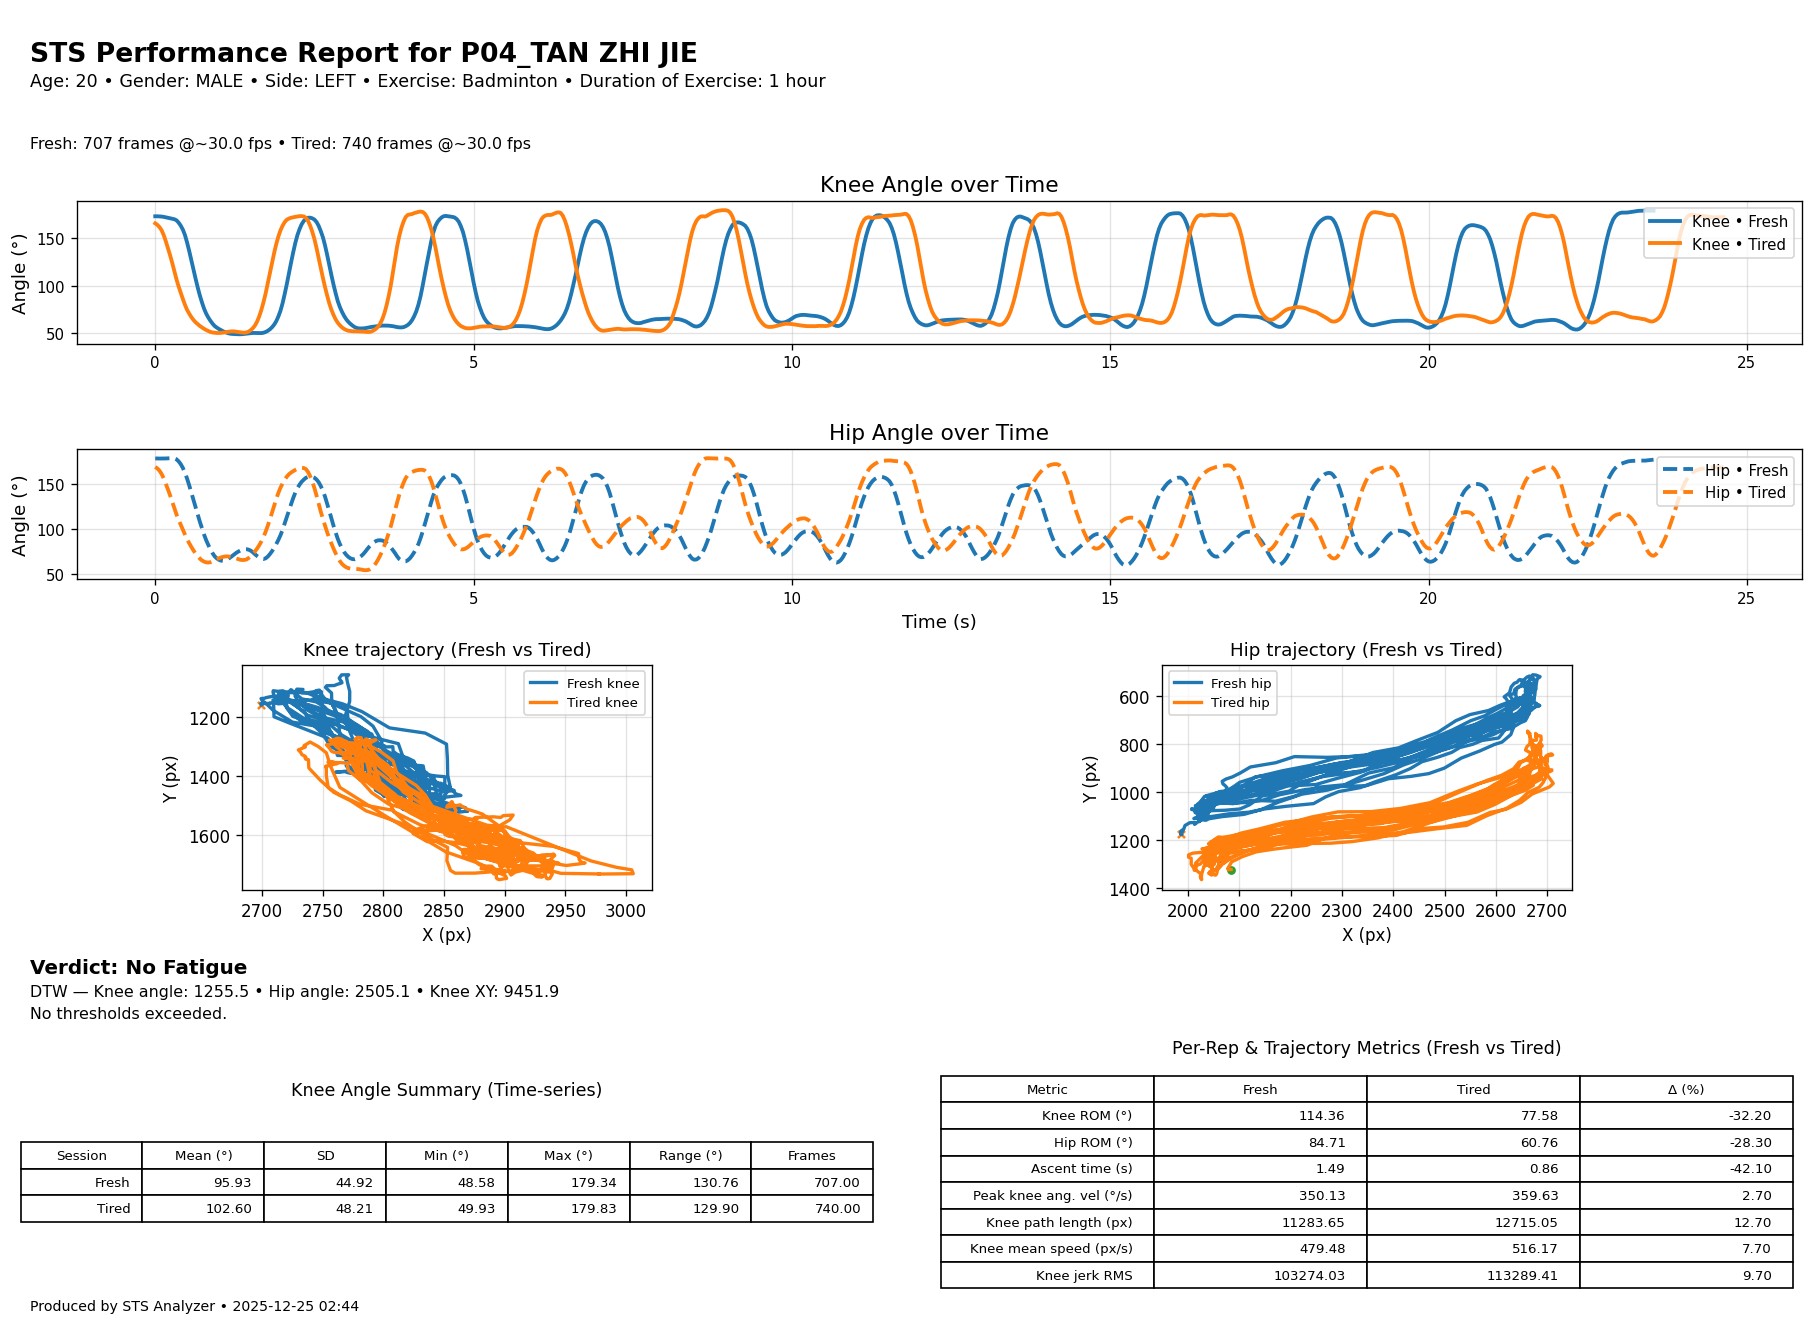


Report saved:
 - outputs\P04_TAN ZHI JIE\P04_TAN ZHI JIE_LEFT_STS_report_20251225-024404.png
 - outputs\P04_TAN ZHI JIE\P04_TAN ZHI JIE_LEFT_STS_report_20251225-024404.pdf


In [88]:
# Toggle: put legends outside to free space (set True to enable)
LEGENDS_OUTSIDE = False

# Bigger page + rebalanced rows to avoid overlaps
fig = plt.figure(figsize=(15, 11), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=7, ncols=4,
    #         title meta  time-series  XY row  verdict tables footer
    height_ratios=[0.7, 0.4, 6.2,      3.0,    1.0,   2.1,   0.3],
    width_ratios=[1,1,1,1]
)

# Title
ax_title = fig.add_subplot(gs[0, :]); ax_title.axis("off")
ax_title.text(0.01, 0.64, title, fontsize=16, weight="bold", ha="left")
ax_title.text(0.01, 0.34, subtitle, fontsize=10.5, ha="left")

# Meta
ax_meta = fig.add_subplot(gs[1, :]); ax_meta.axis("off")
ax_meta.text(0.01, 0.55,
             f"Fresh: {stats_f['n_frames']} frames @~{fps_f:.1f} fps • "
             f"Tired: {stats_t['n_frames']} frames @~{fps_t:.1f} fps",
             fontsize=9.5, ha="left")

# -------- Time-series (split: Knee top, Hip bottom) --------
# sensible y-limits from both sessions
knee_all = np.concatenate([df_fresh["knee_angle_smooth"].values,
                           df_tired["knee_angle_smooth"].values])
hip_all  = np.concatenate([df_fresh["hip_angle_smooth"].values,
                           df_tired["hip_angle_smooth"].values])

def expand_limits(arr, pad=10.0):
    lo, hi = np.nanmin(arr), np.nanmax(arr)
    return lo - pad, hi + pad

knee_ylim = expand_limits(knee_all)
hip_ylim  = expand_limits(hip_all)

# Use more vertical spacing between knee & hip
ts_grid = gs[2, :].subgridspec(
    2, 1,
    height_ratios=[1.1, 1.0],  # almost equal
    hspace=0.08                # MUCH less vertical gap
)

# --- Knee ---
ax_knee = fig.add_subplot(ts_grid[0, 0])
ax_knee.plot(df_fresh["time_s"], df_fresh["knee_angle_smooth"], label="Knee • Fresh", linewidth=2.3)
ax_knee.plot(df_tired["time_s"], df_tired["knee_angle_smooth"], label="Knee • Tired", linewidth=2.3)
ax_knee.set_ylabel("Angle (°)", fontsize=11)
ax_knee.set_title("Knee Angle over Time", fontsize=13, pad=6)
ax_knee.grid(True, alpha=0.35)
ax_knee.set_ylim(*knee_ylim)
ax_knee.tick_params(labelsize=9)
ax_knee.legend(loc="upper right", fontsize=9)

# --- Hip ---
ax_hip = fig.add_subplot(ts_grid[1, 0], sharex=ax_knee)
ax_hip.plot(df_fresh["time_s"], df_fresh["hip_angle_smooth"], label="Hip • Fresh",
            linewidth=2.3, linestyle="--")
ax_hip.plot(df_tired["time_s"], df_tired["hip_angle_smooth"], label="Hip • Tired",
            linewidth=2.3, linestyle="--")
ax_hip.set_xlabel("Time (s)", fontsize=11)
ax_hip.set_ylabel("Angle (°)", fontsize=11)
ax_hip.set_title("Hip Angle over Time", fontsize=13, pad=6)
ax_hip.grid(True, alpha=0.35)
ax_hip.set_ylim(*hip_ylim)
ax_hip.tick_params(labelsize=9)
ax_hip.legend(loc="upper right", fontsize=9)

# -------- XY trajectories (unchanged helpers) --------
ax_knee_xy = fig.add_subplot(gs[3, 0:2])
plot_xy_trajectories(df_fresh, df_tired, joint="knee", ax=ax_knee_xy,
                     title="Knee trajectory (Fresh vs Tired)", box_aspect=0.55)

ax_hip_xy = fig.add_subplot(gs[3, 2:4])
plot_xy_trajectories(df_fresh, df_tired, joint="hip", ax=ax_hip_xy,
                     title="Hip trajectory (Fresh vs Tired)", box_aspect=0.55)

# -------- Verdict (compact, no overlap) --------
ax_ver = fig.add_subplot(gs[4, :]); ax_ver.axis("off")
ax_ver.text(0.01, 0.75, f"Verdict: {verdict_ext}",
            fontsize=12, weight="bold", ha="left")
ax_ver.text(0.01, 0.45,
            f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} • "
            f"Hip angle: {dtw_angles['dtw_hip_angle']:.1f} • "
            f"Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}",
            fontsize=9.5, ha="left")
reasons_text = " • ".join(reasons_ext) if reasons_ext else "No thresholds exceeded."
if len(reasons_text) > 160:
    reasons_text = reasons_text[:157] + "…"
ax_ver.text(0.01, 0.15, reasons_text, fontsize=9.5, ha="left")

# -------- Tables (smaller fonts/scales) --------
ax_tbl1 = fig.add_subplot(gs[5, 0:2]); ax_tbl1.axis("off")
tbl1 = ax_tbl1.table(cellText=summary_df_fmt.values,
                     colLabels=summary_df_fmt.columns,
                     loc="center", cellLoc="right", colLoc="center")
tbl1.auto_set_font_size(False); tbl1.set_fontsize(8); tbl1.scale(0.98, 1.12)
ax_tbl1.set_title("Knee Angle Summary (Time-series)", fontsize=10.5, pad=5)

ax_tbl2 = fig.add_subplot(gs[5, 2:4]); ax_tbl2.axis("off")
tbl2 = ax_tbl2.table(cellText=derived_df_fmt.values,
                     colLabels=derived_df_fmt.columns,
                     loc="center", cellLoc="right", colLoc="center")
tbl2.auto_set_font_size(False); tbl2.set_fontsize(8); tbl2.scale(0.98, 1.12)
ax_tbl2.set_title("Per-Rep & Trajectory Metrics (Fresh vs Tired)\n\n", fontsize=10.5, pad=5)

# Footer
ax_foot = fig.add_subplot(gs[6, :]); ax_foot.axis("off")
ax_foot.text(0.01, 0.5, "Produced by STS Analyzer • " +
             pd.Timestamp.now().strftime("%Y-%m-%d %H:%M"),
             fontsize=8.5, ha="left")

plt.show()

# =========================
# SAVE (PNG + PDF)
# =========================
report_dir = Path("outputs") / p_name
report_dir.mkdir(parents=True, exist_ok=True)
stamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
png_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.png"
pdf_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.pdf"
fig.savefig(png_path, dpi=220, bbox_inches="tight")
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")
print(f"\nReport saved:\n - {png_path}\n - {pdf_path}")

# =========================
# Console summary (toggle)
# =========================
SHOW_CONSOLE = False
if SHOW_CONSOLE:
    print("\n===== Copy-ready Summary =====")
    print(f"Participant: {p_name} ({p_gender}, {p_age}) — Side: {SIDE}")
    print(summary_df_fmt.to_string(index=False))
    print("\nPer-rep/Trajectory (Fresh vs Tired, Δ%):")
    print(derived_df_fmt.to_string(index=False))
    print(f"\nVerdict (basic):   {verdict_basic}  | Reasons: {', '.join(reasons_basic) if reasons_basic else '-'}")
    print(f"Verdict (extended): {verdict_ext}  | Reasons: {', '.join(reasons_ext) if reasons_ext else '-'}")
    print(f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} | "
          f"Hip angle: {dtw_angles['dtw_hip_angle']:.1f} | "
          f"Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}")

### **4. P05_KANG KIM LUWAN**

In [89]:
fresh_video = r"P05_Fresh Squat.mov"
tired_video = r"P05_Tired Squat.mov"

SIDE = "LEFT"         # or "LEFT"
MA_WINDOW = 7          # 5–11 is typical

p_name   = "P05_KANG KIM LUWAN"
p_age    = "52"
p_gender = "FEMALE"
exercise_type = "PICKLEBALL"
exercise_duration = "1 hour"

# Define title and subtitle
title = f"\nSTS Performance Report for {p_name}\n"
subtitle = f"\nAge: {p_age} • Gender: {p_gender} • Side: {SIDE} • Exercise: {exercise_type} • Duration of Exercise: {exercise_duration}\n"

In [90]:
# 1) Extract per-frame data
df_fresh, fps_f = extract_angles_and_xy(fresh_video, SIDE, MA_WINDOW)
df_tired, fps_t = extract_angles_and_xy(tired_video, SIDE, MA_WINDOW)

# 2) Session stats
stats_f = quick_stats(df_fresh)
stats_t = quick_stats(df_tired)

# 3) Reps + per-rep features
reps_f = segment_reps(df_fresh, fps_f, min_separation_s=1.0)
reps_t = segment_reps(df_tired, fps_t, min_separation_s=1.0)
perrep_f = per_rep_features(df_fresh, reps_f) if len(reps_f) else pd.DataFrame()
perrep_t = per_rep_features(df_tired, reps_t) if len(reps_t) else pd.DataFrame()

# 4) Aggregates (fallback to session ROM if reps missing)
def agg_or_fallback(perrep_df, df_ts):
    if perrep_df.empty:
        agg = {
            "knee_ROM": float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5)),
            "hip_ROM":  float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5)),
            "ascent_time_s": np.nan,
            "descent_time_s": np.nan,
            "knee_peak_vel_deg_s": float(np.nanmax(np.abs(df_ts["knee_vel"])))
        }
    else:
        agg = perrep_df.mean(numeric_only=True).to_dict()
        if not np.isfinite(agg.get("knee_ROM", np.nan)):
            agg["knee_ROM"] = float(np.nanpercentile(df_ts["knee_angle_smooth"],95) - np.nanpercentile(df_ts["knee_angle_smooth"],5))
        if not np.isfinite(agg.get("hip_ROM", np.nan)):
            agg["hip_ROM"]  = float(np.nanpercentile(df_ts["hip_angle_smooth"],95)  - np.nanpercentile(df_ts["hip_angle_smooth"],5))
    return agg

agg_f = agg_or_fallback(perrep_f, df_fresh)
agg_t = agg_or_fallback(perrep_t, df_tired)

# 5) Trajectory metrics
traj_f = trajectory_summary(df_fresh)
traj_t = trajectory_summary(df_tired)

# 6) DTW similarities
dtw_angles = dtw_compare_angles(df_fresh, df_tired, n=300)
dtw_kxy    = dtw_compare_knee_xy(df_fresh, df_tired, n=300)

# 7) Verdicts
verdict_basic, reasons_basic = simple_fatigue_flag(stats_f, stats_t)
verdict_ext,  reasons_ext    = fatigue_rule_extended(stats_f, stats_t, agg_f, agg_t)

# Helper formatters
def _fmt(x, nd=2):
    return "" if (x is None or (isinstance(x,float) and not np.isfinite(x))) else round(float(x), nd)
def _pct(f, t):
    if f is None or t is None or not np.isfinite(f) or not np.isfinite(t):
        return ""
    return round(100.0 * (t - f) / max(abs(f), 1e-6), 1)

# Tables (already formatted via format_df)
summary_df = pd.DataFrame([
    {"Session": "Fresh", "Mean (°)": round(stats_f["mean"], 2), "SD": round(stats_f["std"],2),
     "Min (°)": round(stats_f["min"],2), "Max (°)": round(stats_f["max"],2),
     "Range (°)": round(stats_f["range"],2), "Frames": stats_f["n_frames"]},
    {"Session": "Tired", "Mean (°)": round(stats_t["mean"], 2), "SD": round(stats_t["std"],2),
     "Min (°)": round(stats_t["min"],2), "Max (°)": round(stats_t["max"],2),
     "Range (°)": round(stats_t["range"],2), "Frames": stats_t["n_frames"]},
]).fillna("")
summary_df_fmt = format_df(summary_df, 2)

rows = []
rows.append(["Knee ROM (°)",            _fmt(agg_f.get("knee_ROM")),            _fmt(agg_t.get("knee_ROM")),            _pct(agg_f.get("knee_ROM"),            agg_t.get("knee_ROM"))])
rows.append(["Hip ROM (°)",             _fmt(agg_f.get("hip_ROM")),             _fmt(agg_t.get("hip_ROM")),             _pct(agg_f.get("hip_ROM"),             agg_t.get("hip_ROM"))])
rows.append(["Ascent time (s)",         _fmt(agg_f.get("ascent_time_s")),       _fmt(agg_t.get("ascent_time_s")),       _pct(agg_f.get("ascent_time_s"),       agg_t.get("ascent_time_s"))])
rows.append(["Peak knee ang. vel (°/s)",_fmt(agg_f.get("knee_peak_vel_deg_s")), _fmt(agg_t.get("knee_peak_vel_deg_s")), _pct(agg_f.get("knee_peak_vel_deg_s"), agg_t.get("knee_peak_vel_deg_s"))])
rows.append(["Knee path length (px)",   _fmt(traj_f.get("knee_path_len_px")),   _fmt(traj_t.get("knee_path_len_px")),   _pct(traj_f.get("knee_path_len_px"),   traj_t.get("knee_path_len_px"))])
rows.append(["Knee mean speed (px/s)",  _fmt(traj_f.get("knee_mean_speed_px_s")),_fmt(traj_t.get("knee_mean_speed_px_s")),_pct(traj_f.get("knee_mean_speed_px_s"),traj_t.get("knee_mean_speed_px_s"))])
rows.append(["Knee jerk RMS",           _fmt(traj_f.get("knee_jerk_rms")),      _fmt(traj_t.get("knee_jerk_rms")),      _pct(traj_f.get("knee_jerk_rms"),      traj_t.get("knee_jerk_rms"))])

derived_df = pd.DataFrame(rows, columns=["Metric", "Fresh", "Tired", "Δ (%)"])
derived_df = derived_df.replace("", np.nan).dropna(how="all").fillna("")
derived_df_fmt = format_df(derived_df, 2)

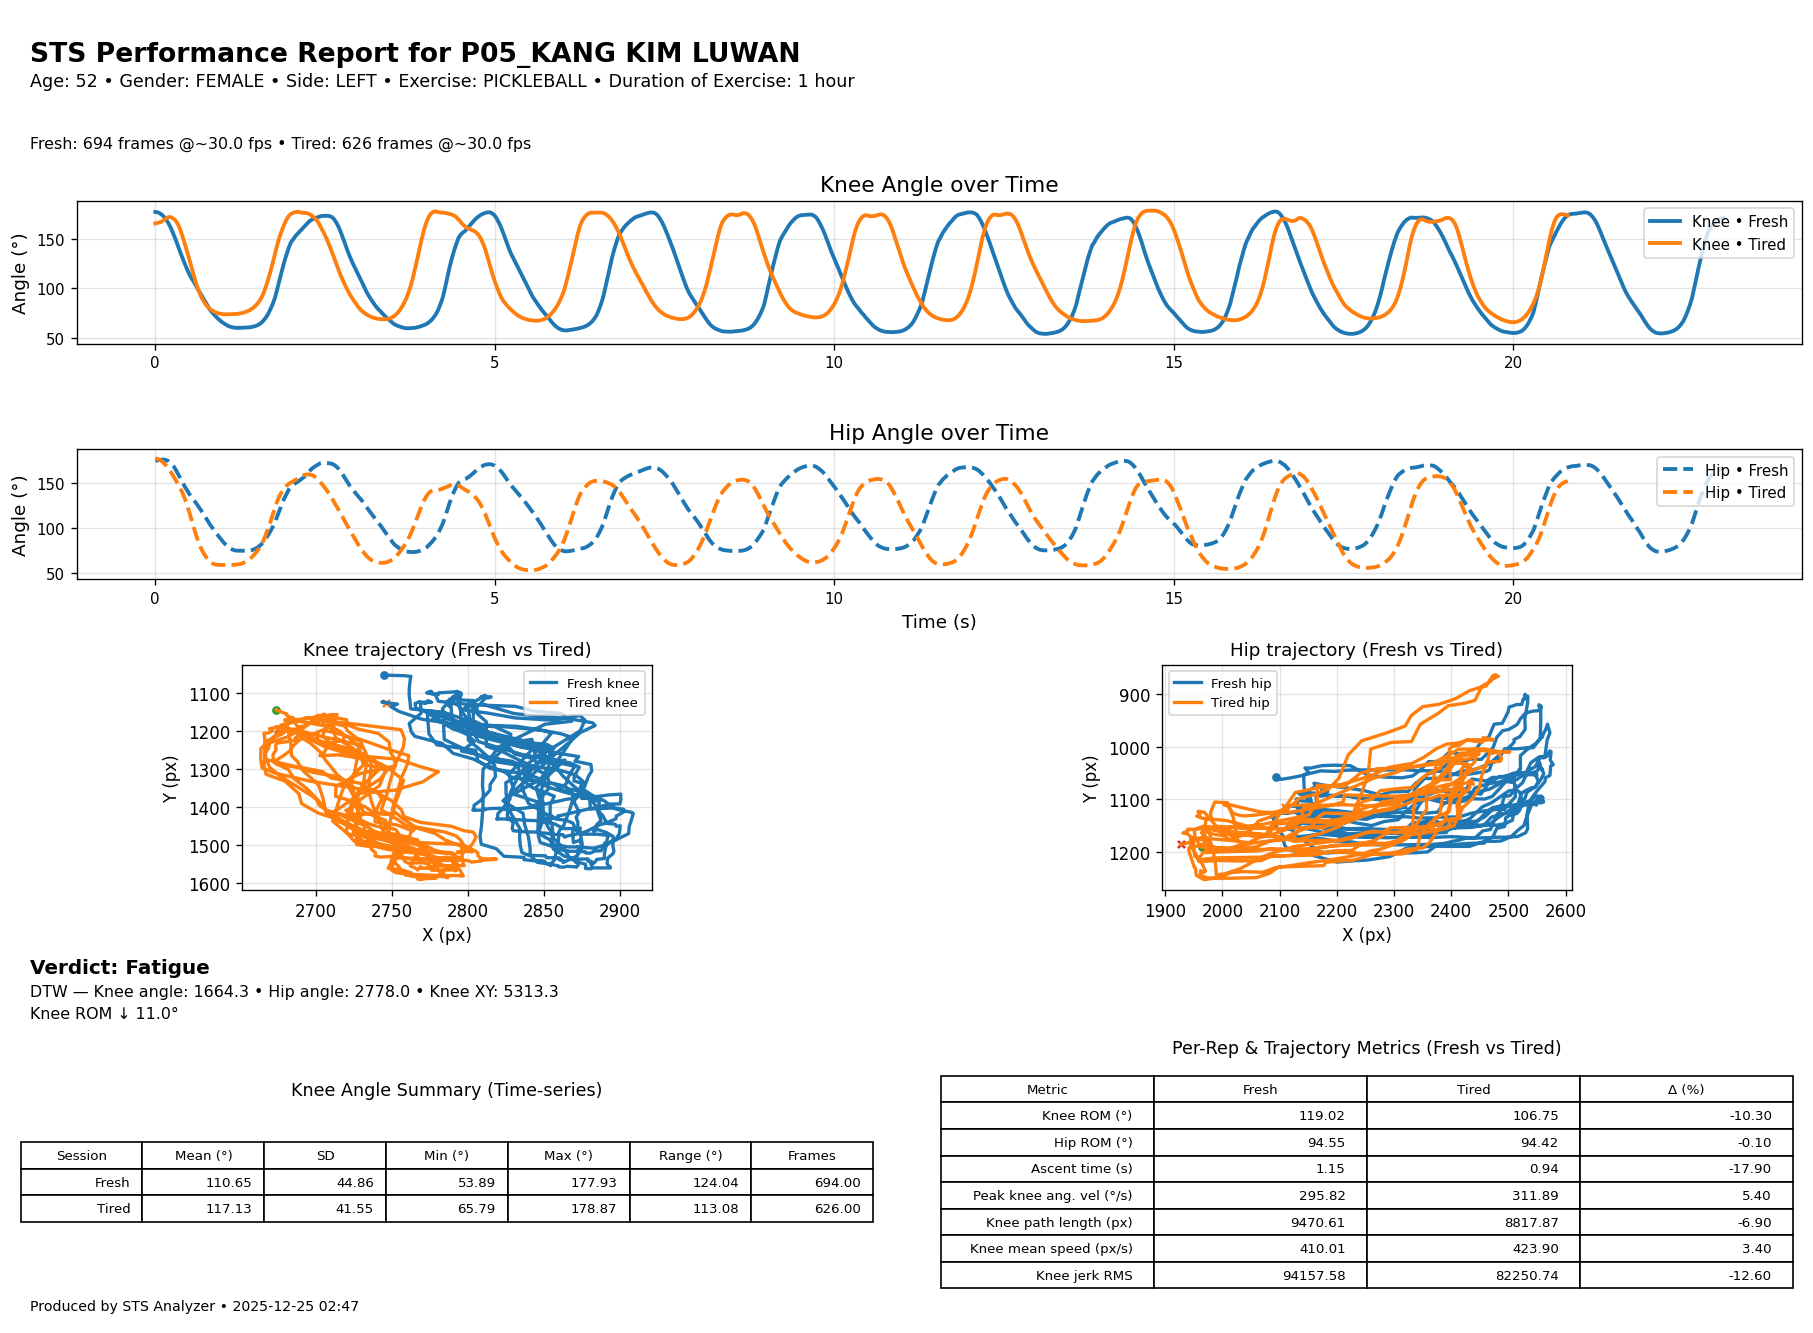


Report saved:
 - outputs\P05_KANG KIM LUWAN\P05_KANG KIM LUWAN_LEFT_STS_report_20251225-024742.png
 - outputs\P05_KANG KIM LUWAN\P05_KANG KIM LUWAN_LEFT_STS_report_20251225-024742.pdf


In [91]:
# Toggle: put legends outside to free space (set True to enable)
LEGENDS_OUTSIDE = False

# Bigger page + rebalanced rows to avoid overlaps
fig = plt.figure(figsize=(15, 11), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=7, ncols=4,
    #         title meta  time-series  XY row  verdict tables footer
    height_ratios=[0.7, 0.4, 6.2,      3.0,    1.0,   2.1,   0.3],
    width_ratios=[1,1,1,1]
)

# Title
ax_title = fig.add_subplot(gs[0, :]); ax_title.axis("off")
ax_title.text(0.01, 0.64, title, fontsize=16, weight="bold", ha="left")
ax_title.text(0.01, 0.34, subtitle, fontsize=10.5, ha="left")

# Meta
ax_meta = fig.add_subplot(gs[1, :]); ax_meta.axis("off")
ax_meta.text(0.01, 0.55,
             f"Fresh: {stats_f['n_frames']} frames @~{fps_f:.1f} fps • "
             f"Tired: {stats_t['n_frames']} frames @~{fps_t:.1f} fps",
             fontsize=9.5, ha="left")

# -------- Time-series (split: Knee top, Hip bottom) --------
# sensible y-limits from both sessions
knee_all = np.concatenate([df_fresh["knee_angle_smooth"].values,
                           df_tired["knee_angle_smooth"].values])
hip_all  = np.concatenate([df_fresh["hip_angle_smooth"].values,
                           df_tired["hip_angle_smooth"].values])

def expand_limits(arr, pad=10.0):
    lo, hi = np.nanmin(arr), np.nanmax(arr)
    return lo - pad, hi + pad

knee_ylim = expand_limits(knee_all)
hip_ylim  = expand_limits(hip_all)

# Use more vertical spacing between knee & hip
ts_grid = gs[2, :].subgridspec(
    2, 1,
    height_ratios=[1.1, 1.0],  # almost equal
    hspace=0.08                # MUCH less vertical gap
)

# --- Knee ---
ax_knee = fig.add_subplot(ts_grid[0, 0])
ax_knee.plot(df_fresh["time_s"], df_fresh["knee_angle_smooth"], label="Knee • Fresh", linewidth=2.3)
ax_knee.plot(df_tired["time_s"], df_tired["knee_angle_smooth"], label="Knee • Tired", linewidth=2.3)
ax_knee.set_ylabel("Angle (°)", fontsize=11)
ax_knee.set_title("Knee Angle over Time", fontsize=13, pad=6)
ax_knee.grid(True, alpha=0.35)
ax_knee.set_ylim(*knee_ylim)
ax_knee.tick_params(labelsize=9)
ax_knee.legend(loc="upper right", fontsize=9)

# --- Hip ---
ax_hip = fig.add_subplot(ts_grid[1, 0], sharex=ax_knee)
ax_hip.plot(df_fresh["time_s"], df_fresh["hip_angle_smooth"], label="Hip • Fresh",
            linewidth=2.3, linestyle="--")
ax_hip.plot(df_tired["time_s"], df_tired["hip_angle_smooth"], label="Hip • Tired",
            linewidth=2.3, linestyle="--")
ax_hip.set_xlabel("Time (s)", fontsize=11)
ax_hip.set_ylabel("Angle (°)", fontsize=11)
ax_hip.set_title("Hip Angle over Time", fontsize=13, pad=6)
ax_hip.grid(True, alpha=0.35)
ax_hip.set_ylim(*hip_ylim)
ax_hip.tick_params(labelsize=9)
ax_hip.legend(loc="upper right", fontsize=9)

# -------- XY trajectories (unchanged helpers) --------
ax_knee_xy = fig.add_subplot(gs[3, 0:2])
plot_xy_trajectories(df_fresh, df_tired, joint="knee", ax=ax_knee_xy,
                     title="Knee trajectory (Fresh vs Tired)", box_aspect=0.55)

ax_hip_xy = fig.add_subplot(gs[3, 2:4])
plot_xy_trajectories(df_fresh, df_tired, joint="hip", ax=ax_hip_xy,
                     title="Hip trajectory (Fresh vs Tired)", box_aspect=0.55)

# -------- Verdict (compact, no overlap) --------
ax_ver = fig.add_subplot(gs[4, :]); ax_ver.axis("off")
ax_ver.text(0.01, 0.75, f"Verdict: {verdict_ext}",
            fontsize=12, weight="bold", ha="left")
ax_ver.text(0.01, 0.45,
            f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} • "
            f"Hip angle: {dtw_angles['dtw_hip_angle']:.1f} • "
            f"Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}",
            fontsize=9.5, ha="left")
reasons_text = " • ".join(reasons_ext) if reasons_ext else "No thresholds exceeded."
if len(reasons_text) > 160:
    reasons_text = reasons_text[:157] + "…"
ax_ver.text(0.01, 0.15, reasons_text, fontsize=9.5, ha="left")

# -------- Tables (smaller fonts/scales) --------
ax_tbl1 = fig.add_subplot(gs[5, 0:2]); ax_tbl1.axis("off")
tbl1 = ax_tbl1.table(cellText=summary_df_fmt.values,
                     colLabels=summary_df_fmt.columns,
                     loc="center", cellLoc="right", colLoc="center")
tbl1.auto_set_font_size(False); tbl1.set_fontsize(8); tbl1.scale(0.98, 1.12)
ax_tbl1.set_title("Knee Angle Summary (Time-series)", fontsize=10.5, pad=5)

ax_tbl2 = fig.add_subplot(gs[5, 2:4]); ax_tbl2.axis("off")
tbl2 = ax_tbl2.table(cellText=derived_df_fmt.values,
                     colLabels=derived_df_fmt.columns,
                     loc="center", cellLoc="right", colLoc="center")
tbl2.auto_set_font_size(False); tbl2.set_fontsize(8); tbl2.scale(0.98, 1.12)
ax_tbl2.set_title("Per-Rep & Trajectory Metrics (Fresh vs Tired)\n\n", fontsize=10.5, pad=5)

# Footer
ax_foot = fig.add_subplot(gs[6, :]); ax_foot.axis("off")
ax_foot.text(0.01, 0.5, "Produced by STS Analyzer • " +
             pd.Timestamp.now().strftime("%Y-%m-%d %H:%M"),
             fontsize=8.5, ha="left")

plt.show()

# =========================
# SAVE (PNG + PDF)
# =========================
report_dir = Path("outputs") / p_name
report_dir.mkdir(parents=True, exist_ok=True)
stamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
png_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.png"
pdf_path  = report_dir / f"{p_name}_{SIDE}_STS_report_{stamp}.pdf"
fig.savefig(png_path, dpi=220, bbox_inches="tight")
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")
print(f"\nReport saved:\n - {png_path}\n - {pdf_path}")

# =========================
# Console summary (toggle)
# =========================
SHOW_CONSOLE = False
if SHOW_CONSOLE:
    print("\n===== Copy-ready Summary =====")
    print(f"Participant: {p_name} ({p_gender}, {p_age}) — Side: {SIDE}")
    print(summary_df_fmt.to_string(index=False))
    print("\nPer-rep/Trajectory (Fresh vs Tired, Δ%):")
    print(derived_df_fmt.to_string(index=False))
    print(f"\nVerdict (basic):   {verdict_basic}  | Reasons: {', '.join(reasons_basic) if reasons_basic else '-'}")
    print(f"Verdict (extended): {verdict_ext}  | Reasons: {', '.join(reasons_ext) if reasons_ext else '-'}")
    print(f"DTW — Knee angle: {dtw_angles['dtw_knee_angle']:.1f} | "
          f"Hip angle: {dtw_angles['dtw_hip_angle']:.1f} | "
          f"Knee XY: {dtw_kxy['dtw_knee_xy']:.1f}")